In [12]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import algorithms.calibrate_camera as calibrate_camera
import algorithms.processing_pipeline as processing_pipeline
import algorithms.image_transformations as image_transformations


from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
test_images = glob.glob('test_images/*.jpg')
test_image = test_images[0]

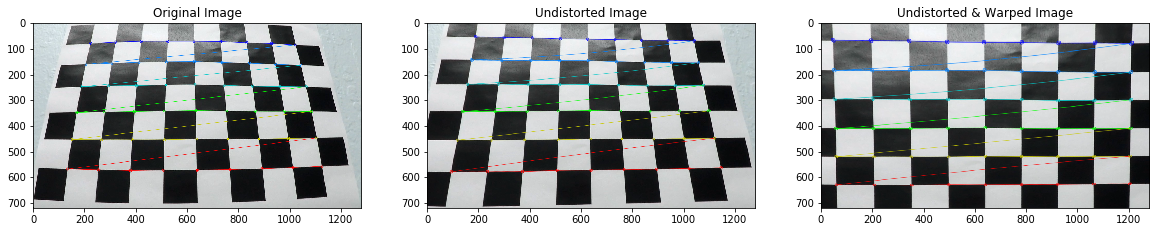

In [8]:
cemera_caliration_path = 'camera_cal/calibration3.jpg'
img, mtx, dist_coef = calibrate_camera.undistort_and_warp(cemera_caliration_path)

In [ ]:
def process_video_pipeline(image):

	## Distort image and warp
# 	img = cv2.imread(image)
	img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


	img_undist = image_transformations.undistort_image(img, mtx, dist_coef)

	src_points = [(290, 660), (1020, 660), (595, 450), (690, 450)]
	dst_points = [(200, 720), (1080, 720), (200, -500), (1080, -500)]

	img_warped, M, M_inv = image_transformations.warp_image(img_undist, src_points, dst_points)

	## Color masks
	img_hsv = cv2.cvtColor(img_warped, cv2.COLOR_RGB2HSV)

	# Define thresholds for white lines
	white_hsv_low  = np.array([ 0,   0,   250])
	white_hsv_high = np.array([ 255,  80, 255])

	# Define thresholds for yellow lines
	yellow_hsv_low  = np.array([ 0,  100,  100])
	yellow_hsv_high = np.array([ 80, 255, 255])

	img_mask_white, img_white = image_transformations.color_mask(img_hsv, img_warped, white_hsv_low, white_hsv_high)
	img_mask_yellow, img_yellow = image_transformations.color_mask(img_hsv, img_warped, yellow_hsv_low, yellow_hsv_high)

	img_color = cv2.bitwise_or(img_white, img_yellow)
	img_mask = cv2.bitwise_or(img_mask_white, img_mask_yellow)


	## Sobel filter
	kernel_size = 9
	img_blur = image_transformations.gaussian_blur(img_warped, kernel=kernel_size)
	img_hls = cv2.cvtColor(img_warped, cv2.COLOR_RGB2HLS)

	img_gs = img_hls[:, :, 1]
	img_abs_x = image_transformations.abs_sobel(img_gs,'x', 5, (50, 225))
	img_abs_y = image_transformations.abs_sobel(img_gs,'y', 5, (50, 225))

	img_sobel = np.copy(cv2.bitwise_or(img_abs_x, img_abs_y))


	## Combine masks
	white_hsv_low  = np.array([ 0,   0,   250])
	white_hsv_high = np.array([ 255,  80, 255])

	# Define thresholds for yellow lines
	yellow_hsv_low  = np.array([ 0,  100,  100])
	yellow_hsv_high = np.array([ 80, 255, 255])

	img_mask_white, img_white = image_transformations.color_mask(img_hsv, img_warped, white_hsv_low, white_hsv_high)
	img_mask_yellow, img_yellow = image_transformations.color_mask(img_hsv, img_warped, yellow_hsv_low, yellow_hsv_high)

	img_color = cv2.bitwise_or(img_white, img_yellow)
	img_mask = cv2.bitwise_or(img_mask_white, img_mask_yellow)


	img_blur = image_transformations.gaussian_blur(img_warped, kernel=kernel_size)
	img_hls = cv2.cvtColor(img_warped, cv2.COLOR_RGB2HLS)

	img_gs = img_hls[:, :, 1]
	img_abs_x = image_transformations.abs_sobel(img_gs,'x', 5, (50, 225))
	img_abs_y = image_transformations.abs_sobel(img_gs,'y', 5, (50, 225))

	img_sobel = np.copy(cv2.bitwise_or(img_abs_x, img_abs_y))

	image_combined = np.zeros_like(img_sobel)
	image_combined[(img_mask>=.5)|(img_sobel>=.5)]=1


	## 

	out_img, left_fit, right_fit, nonzerox, nonzeroy, left_lane_inds, right_lane_inds = \
                                                    image_transformations.image_hist(image_combined)

	binary_warped = image_combined
	# Generate x and y values for plotting
	ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
	left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
	right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

	out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
	out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]


	## Curvature

	y_eval = np.max(ploty)
	left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
	right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
	leftx = nonzerox[left_lane_inds]
	lefty = nonzeroy[left_lane_inds] 
	rightx = nonzerox[right_lane_inds]
	righty = nonzeroy[right_lane_inds]

	# Define conversions in x and y from pixels space to meters
	ym_per_pix = 30/720 # meters per pixel in y dimension
	xm_per_pix = 3.7/700 # meters per pixel in x dimension

	# Fit new polynomials to x,y in world space
	left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
	right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
	# Calculate the new radii of curvature
	left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
	right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
	# Now our radius of curvature is in meters
	print(left_curverad, 'm', right_curverad, 'm')


	## Warp results back

	warped = image_combined

	# Create an image to draw the lines on
	warp_zero = np.zeros_like(warped).astype(np.uint8)
	color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

	# Recast the x and y points into usable format for cv2.fillPoly()
	pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
	pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
	pts = np.hstack((pts_left, pts_right))

	# Draw the lane onto the warped blank image
	cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

	# Warp the blank back to original image space using inverse perspective matrix (Minv)
	newwarp = cv2.warpPerspective(color_warp, M_inv, (img.shape[1], img.shape[0])) 
	# Combine the result with the original image
	result = cv2.addWeighted(img_undist, 1, newwarp, 0.3, 0)

	return(result)


In [13]:
print(test_image)
img = process_video_pipeline(test_image)

test_images/straight_lines1.jpg
2251.63028258 m 2009.63341296 m


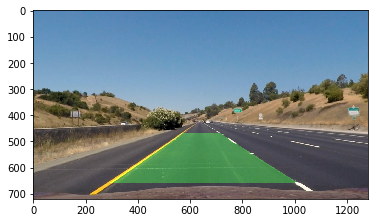

In [14]:
plt.imshow(img, cmap='gray')

In [18]:
set_prev = 0
do_diagnosis = 0

project_output = 'output/project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4");
white_clip = clip1.fl_image(process_video_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False);

948.82849787 m 1049.4930657 m
[MoviePy] >>>> Building video output/project_video_output.mp4
[MoviePy] Writing video output/project_video_output.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

948.82849787 m 1049.4930657 m


  0%|          | 1/1261 [00:00<04:09,  5.04it/s]

834.77598796

  0%|          | 2/1261 [00:00<04:11,  5.01it/s]

 m 1001.96556852 m
824.28339468

  0%|          | 3/1261 [00:00<04:12,  4.99it/s]

 m 1103.7141442 m
616.571414484 m 1079.40859711 m


  0%|          | 5/1261 [00:01<04:13,  4.95it/s]

636.685032065 m 928.252202845 m
676.409421519 m 1276.86540165 m


  1%|          | 7/1261 [00:01<04:03,  5.16it/s]

634.017893291 m 1385.51043985 m
737.977214049 m 962.582156346 m


  1%|          | 9/1261 [00:01<03:53,  5.36it/s]

701.140315214 m 1010.63219922 m
696.537897812 m 941.633558084 m


  1%|          | 12/1261 [00:02<03:50,  5.41it/s]

656.005761113 m 948.250089451 m
529.356705908 m 1231.30441931 m


  1%|          | 13/1261 [00:02<03:57,  5.26it/s]

640.290906316 m 1749.38925999 m
570.086404675 m 1322.07729565 m


  1%|          | 15/1261 [00:02<04:00,  5.18it/s]

478.383553983 m 1455.85315692 m
413.991659359 m 1217.56345292 m


  1%|▏         | 17/1261 [00:03<04:12,  4.92it/s]

482.936821592 m 1634.35140939 m
427.152881663

  2%|▏         | 19/1261 [00:03<04:02,  5.12it/s]

 m 1812.27838698 m
501.646448878 m 1947.98303881 m


  2%|▏         | 20/1261 [00:03<04:09,  4.97it/s]

1329.78400551 m 8299.50211532 m


  2%|▏         | 21/1261 [00:04<04:12,  4.91it/s]

1421.44423908 m 1506.96197143 m
2074.16832566 m 1403.75435018 m


  2%|▏         | 23/1261 [00:04<04:19,  4.76it/s]

2731.03742427 m 1208.17942312 m
2380.78886302

  2%|▏         | 25/1261 [00:04<04:20,  4.74it/s]

 m 1265.54308717 m
2105.60420338 m 767.517798599 m


  2%|▏         | 26/1261 [00:05<04:21,  4.72it/s]

1664.91078128 m 984.465179186 m


  2%|▏         | 27/1261 [00:05<04:21,  4.72it/s]

1426.5571597 m 958.454233028 m
875.950781606 m

  2%|▏         | 29/1261 [00:05<04:07,  4.98it/s]

 894.524242242 m
484.303910411 m 821.290035279 m
6670.56790782 m 897.170137397 m


  2%|▏         | 31/1261 [00:06<04:01,  5.10it/s]

596.94746106 m 825.657235336 m
500.953315047 m 1598.23386189 m


  3%|▎         | 33/1261 [00:06<04:00,  5.10it/s]

763.695524596 m 5224.02253807 m
778.194418921 m 933.564954376 m


  3%|▎         | 35/1261 [00:06<04:05,  5.00it/s]

727.851442099 m 1067.1177064 m
655.427356862 m 963.87820965 m


  3%|▎         | 37/1261 [00:07<04:18,  4.74it/s]

673.044531681 m 901.314974458 m
590.953413486 m 734.827579372 m


  3%|▎         | 39/1261 [00:07<04:11,  4.86it/s]

595.244627432 m 835.39549395 m


  3%|▎         | 40/1261 [00:07<04:09,  4.89it/s]

670.776119484 m 844.774050504 m


  3%|▎         | 41/1261 [00:08<04:16,  4.75it/s]

1010.92027845 m 743.737942376 m


  3%|▎         | 42/1261 [00:08<04:20,  4.67it/s]

563.4276744 m 876.044932252 m


  3%|▎         | 43/1261 [00:08<04:35,  4.41it/s]

540.910780609 m 757.275787703 m


  3%|▎         | 44/1261 [00:08<04:47,  4.23it/s]

502.310330887 m 936.972315949 m


  4%|▎         | 45/1261 [00:09<04:42,  4.31it/s]

485.366162822 m 2202.81759345 m


  4%|▎         | 46/1261 [00:09<04:36,  4.40it/s]

592.600811795 m 1865.35820893 m


  4%|▎         | 47/1261 [00:09<04:33,  4.44it/s]

547.659003055 m 879.603264785 m


  4%|▍         | 48/1261 [00:09<04:27,  4.53it/s]

556.321534478 m 985.250914281 m


  4%|▍         | 49/1261 [00:10<04:34,  4.41it/s]

497.723391046 m 899.631681576 m


  4%|▍         | 50/1261 [00:10<04:25,  4.56it/s]

517.608394667 m 634.589430134 m


  4%|▍         | 51/1261 [00:10<04:28,  4.51it/s]

541.185327208 m 725.25498556 m


  4%|▍         | 52/1261 [00:10<04:37,  4.36it/s]

501.883142888 m 777.355219452 m


  4%|▍         | 53/1261 [00:10<04:44,  4.25it/s]

335.886452155 m 765.591702795 m


  4%|▍         | 54/1261 [00:11<04:45,  4.23it/s]

326.021216196 m 766.836624733 m


  4%|▍         | 55/1261 [00:11<04:50,  4.15it/s]

342.178375311 m 829.615945538 m


  4%|▍         | 56/1261 [00:11<04:49,  4.16it/s]

461.95030214 m 807.047804346 m


  5%|▍         | 57/1261 [00:11<04:54,  4.09it/s]

490.382346727 m 904.245113096 m


  5%|▍         | 58/1261 [00:12<04:47,  4.18it/s]

735.973865305 m 1951.3947224 m


  5%|▍         | 59/1261 [00:12<04:44,  4.22it/s]

973.163359084 m 797.655662446 m


  5%|▍         | 60/1261 [00:12<04:45,  4.21it/s]

1245.52618545 m 880.058291643 m


  5%|▍         | 61/1261 [00:12<05:18,  3.77it/s]

991.427695509 m 979.15708783 m


  5%|▍         | 62/1261 [00:13<05:09,  3.87it/s]

2117.92675885 m 993.209250106 m


  5%|▍         | 63/1261 [00:13<05:07,  3.90it/s]

1208.29286207 m 859.759730229 m


  5%|▌         | 64/1261 [00:13<04:57,  4.02it/s]

1611.99052581 m 901.345593255 m


  5%|▌         | 65/1261 [00:13<05:01,  3.97it/s]

1770.20196736 m 880.151761631 m


  5%|▌         | 66/1261 [00:14<05:00,  3.98it/s]

865.64901786 m 1194.13545089 m


  5%|▌         | 67/1261 [00:14<05:05,  3.91it/s]

1665.54303322 m 993.71178703 m


  5%|▌         | 68/1261 [00:14<04:53,  4.07it/s]

1091.70547292 m 1019.93410983 m


  5%|▌         | 69/1261 [00:14<04:48,  4.13it/s]

948.124847579 m 1206.90361793 m


  6%|▌         | 70/1261 [00:15<04:50,  4.10it/s]

717.029356658 m 2163.31371432 m


  6%|▌         | 71/1261 [00:15<04:41,  4.22it/s]

662.740128202 m 1754.05604374 m


  6%|▌         | 72/1261 [00:15<04:36,  4.31it/s]

607.97277221 m 1735.15193032 m


  6%|▌         | 73/1261 [00:15<04:32,  4.36it/s]

614.552328179 m 1799.48120985 m


  6%|▌         | 74/1261 [00:16<04:25,  4.48it/s]

542.128991574 m 1408.04209839 m


  6%|▌         | 75/1261 [00:16<04:21,  4.53it/s]

604.627842637 m 951.679372484 m


  6%|▌         | 76/1261 [00:16<04:21,  4.53it/s]

567.759025451 m 929.11752125 m


  6%|▌         | 77/1261 [00:16<04:30,  4.38it/s]

591.865132155 m 991.327980586 m


  6%|▌         | 78/1261 [00:16<04:37,  4.26it/s]

434.689702762 m 1078.71506098 m


  6%|▋         | 79/1261 [00:17<04:41,  4.20it/s]

316.965803142 m 1131.77246602 m


  6%|▋         | 80/1261 [00:17<04:42,  4.18it/s]

610.467524685 m 962.592947275 m


  6%|▋         | 81/1261 [00:17<04:37,  4.26it/s]

636.008640833 m 936.865667891 m


  7%|▋         | 82/1261 [00:17<04:32,  4.32it/s]

809.902224932 m 1099.63125676 m


  7%|▋         | 83/1261 [00:18<04:28,  4.39it/s]

1351.93299398 m 6921.33109325 m


  7%|▋         | 84/1261 [00:18<04:24,  4.46it/s]

1416.55015408 m 4236.59580089 m


  7%|▋         | 85/1261 [00:18<04:29,  4.36it/s]

1251.21607451 m 1110.36948441 m


  7%|▋         | 86/1261 [00:18<04:23,  4.45it/s]

1179.20965371 m 1043.25893009 m


  7%|▋         | 87/1261 [00:19<04:34,  4.27it/s]

1027.12639634 m 953.840695214 m


  7%|▋         | 88/1261 [00:19<04:41,  4.17it/s]

837.756874993 m 819.663664645 m


  7%|▋         | 89/1261 [00:19<04:35,  4.26it/s]

962.136436584 m 792.528398743 m


  7%|▋         | 90/1261 [00:19<04:26,  4.40it/s]

747.872239132 m 776.956840438 m


  7%|▋         | 91/1261 [00:20<04:36,  4.23it/s]

4170.16215202 m 797.410568665 m


  7%|▋         | 92/1261 [00:20<04:31,  4.31it/s]

138265.52114 m 825.825332057 m


  7%|▋         | 93/1261 [00:20<04:28,  4.36it/s]

645.315073524 m 1008.51036011 m


  7%|▋         | 94/1261 [00:20<04:35,  4.24it/s]

925.722058498 m 1236.38870047 m


  8%|▊         | 95/1261 [00:20<04:47,  4.06it/s]

1196.72476558 m 1771.31965258 m


  8%|▊         | 96/1261 [00:21<04:50,  4.01it/s]

575.91374278 m 1455.80325705 m


  8%|▊         | 97/1261 [00:21<04:44,  4.10it/s]

584.776688839 m 1417.49015876 m


  8%|▊         | 98/1261 [00:21<04:45,  4.07it/s]

620.012633245 m 1527.2396211 m


  8%|▊         | 99/1261 [00:22<05:01,  3.86it/s]

512.646252974 m 1052.10428738 m


  8%|▊         | 100/1261 [00:22<04:59,  3.87it/s]

1254.83954264 m 709.720227302 m


  8%|▊         | 101/1261 [00:22<05:02,  3.83it/s]

1096.81899276 m 659.673745755 m


  8%|▊         | 102/1261 [00:22<05:11,  3.73it/s]

1600.48787101 m 673.721371437 m


  8%|▊         | 103/1261 [00:23<05:20,  3.61it/s]

1829.70112118 m 729.859663749 m


  8%|▊         | 104/1261 [00:23<05:05,  3.79it/s]

343.98394157 m 735.129407228 m


  8%|▊         | 105/1261 [00:23<05:00,  3.85it/s]

565.602622961 m 715.131763742 m


  8%|▊         | 106/1261 [00:23<04:46,  4.03it/s]

855.046172847 m 898.83949892 m


  8%|▊         | 107/1261 [00:24<04:40,  4.11it/s]

741.25716096 m 790.715168176 m


  9%|▊         | 108/1261 [00:24<04:44,  4.05it/s]

676.270240071 m 1922.67123883 m


  9%|▊         | 109/1261 [00:24<04:41,  4.09it/s]

672.933994636 m 6607.52333734 m


  9%|▊         | 110/1261 [00:24<04:41,  4.09it/s]

746.850638696 m 1105.58761715 m


  9%|▉         | 111/1261 [00:25<04:46,  4.01it/s]

785.076199174 m 1055.75644495 m


  9%|▉         | 112/1261 [00:25<04:42,  4.07it/s]

625.462225934 m 1304.69248312 m


  9%|▉         | 113/1261 [00:25<04:38,  4.12it/s]

750.760198553 m 840.892325869 m


  9%|▉         | 114/1261 [00:25<04:29,  4.25it/s]

767.609424083 m 1002.2789702 m


  9%|▉         | 115/1261 [00:26<04:39,  4.10it/s]

942.511440327 m 958.882509729 m


  9%|▉         | 116/1261 [00:26<04:36,  4.14it/s]

1126.07726359 m 892.413801179 m


  9%|▉         | 117/1261 [00:26<04:30,  4.23it/s]

542.489371338 m 893.663047247 m


  9%|▉         | 118/1261 [00:26<04:41,  4.06it/s]

712.002870715 m 855.580600208 m


  9%|▉         | 119/1261 [00:26<04:44,  4.01it/s]

629.497870087 m 949.164206459 m


 10%|▉         | 120/1261 [00:27<04:36,  4.13it/s]

712.875972977 m 1030.62559283 m


 10%|▉         | 121/1261 [00:27<04:26,  4.27it/s]

724.159318057 m 703.773114606 m


 10%|▉         | 122/1261 [00:27<04:21,  4.35it/s]

608.870503696 m 728.019264654 m


 10%|▉         | 123/1261 [00:27<04:21,  4.35it/s]

609.941401967 m 677.414543164 m


 10%|▉         | 124/1261 [00:28<04:19,  4.39it/s]

573.711488351 m 654.4761113 m


 10%|▉         | 125/1261 [00:28<04:27,  4.24it/s]

714.039518009 m 671.616341064 m


 10%|▉         | 126/1261 [00:28<04:34,  4.14it/s]

598.555797943 m 632.959629701 m


 10%|█         | 127/1261 [00:28<04:45,  3.97it/s]

541.643875923 m 617.132949979 m


 10%|█         | 128/1261 [00:29<04:59,  3.79it/s]

660.037764141 m 661.248805659 m


 10%|█         | 129/1261 [00:29<04:57,  3.80it/s]

917.578652838 m 618.42208433 m


 10%|█         | 130/1261 [00:29<04:51,  3.88it/s]

444.638811865 m 758.845669717 m


 10%|█         | 131/1261 [00:29<04:54,  3.84it/s]

418.506956864 m 816.874467779 m


 10%|█         | 132/1261 [00:30<04:56,  3.80it/s]

459.159864088 m 853.006931327 m


 11%|█         | 133/1261 [00:30<04:49,  3.90it/s]

527.025424293 m 1053.56411144 m


 11%|█         | 134/1261 [00:30<04:58,  3.77it/s]

824.693733155 m 865.120048399 m


 11%|█         | 135/1261 [00:31<05:09,  3.64it/s]

844.570350828 m 891.060114409 m


 11%|█         | 136/1261 [00:31<05:08,  3.65it/s]

1380.99537386 m 845.438255688 m


 11%|█         | 137/1261 [00:31<04:59,  3.75it/s]

842.192676997 m 891.035001235 m


 11%|█         | 138/1261 [00:31<04:56,  3.79it/s]

1393.90451597 m 1014.14739688 m


 11%|█         | 139/1261 [00:32<04:56,  3.78it/s]

1713.14003492 m 894.917959539 m


 11%|█         | 140/1261 [00:32<04:51,  3.84it/s]

1188.3514596 m 883.349985291 m


 11%|█         | 141/1261 [00:32<04:54,  3.80it/s]

1161.01331128 m 1077.37642519 m


 11%|█▏        | 142/1261 [00:32<05:15,  3.55it/s]

2723.58387215 m 936.718398161 m


 11%|█▏        | 143/1261 [00:33<05:08,  3.62it/s]

28442.5793979 m 822.987966384 m


 11%|█▏        | 144/1261 [00:33<05:01,  3.71it/s]

908.326904617 m 788.104022926 m


 11%|█▏        | 145/1261 [00:33<04:56,  3.77it/s]

994.762239399 m 789.84922198 m


 12%|█▏        | 146/1261 [00:33<04:58,  3.73it/s]

745.272995128 m 1952.24747374 m


 12%|█▏        | 147/1261 [00:34<05:00,  3.71it/s]

940.294500447 m 1705.48477859 m


 12%|█▏        | 148/1261 [00:34<04:53,  3.79it/s]

1227.59400543 m 1326.75573438 m


 12%|█▏        | 149/1261 [00:34<05:07,  3.61it/s]

1296.00308815 m 1180.70274221 m


 12%|█▏        | 150/1261 [00:35<05:34,  3.32it/s]

939.029694035 m 1349.24446904 m


 12%|█▏        | 151/1261 [00:35<05:48,  3.19it/s]

1437.53113203 m 866.653421571 m


 12%|█▏        | 152/1261 [00:35<05:33,  3.32it/s]

1762.29777641 m 948.222507937 m


 12%|█▏        | 153/1261 [00:36<05:29,  3.36it/s]

965.082700549 m 970.085344015 m


 12%|█▏        | 154/1261 [00:36<05:17,  3.49it/s]

716.042621022 m 980.036733268 m


 12%|█▏        | 155/1261 [00:36<05:04,  3.63it/s]

707.83126899 m 932.706693314 m


 12%|█▏        | 156/1261 [00:36<04:53,  3.77it/s]

1329.16276588 m 828.078444398 m


 12%|█▏        | 157/1261 [00:37<05:24,  3.40it/s]

1857.13682407 m 849.405649998 m


 13%|█▎        | 158/1261 [00:37<05:18,  3.46it/s]

161274.699668 m 876.28152664 m


 13%|█▎        | 159/1261 [00:37<05:06,  3.59it/s]

928.009726206 m 915.22547838 m


 13%|█▎        | 160/1261 [00:38<05:13,  3.51it/s]

803.195817122 m 852.891232402 m


 13%|█▎        | 161/1261 [00:38<05:10,  3.54it/s]

920.985252089 m 844.874043048 m


 13%|█▎        | 162/1261 [00:38<05:03,  3.62it/s]

717.958459923 m 884.1735465 m


 13%|█▎        | 163/1261 [00:38<05:07,  3.57it/s]

830.45090223 m 2083.28724969 m


 13%|█▎        | 164/1261 [00:39<04:59,  3.66it/s]

766.873748588 m 1723.58862228 m


 13%|█▎        | 165/1261 [00:39<04:51,  3.76it/s]

834.754596433 m 1478.69304681 m


 13%|█▎        | 166/1261 [00:39<04:41,  3.90it/s]

517.766801619 m 1655.77118644 m


 13%|█▎        | 167/1261 [00:39<04:46,  3.82it/s]

575.633570658 m 1826.76017314 m


 13%|█▎        | 168/1261 [00:40<04:46,  3.82it/s]

586.712632128 m 2878.6752507 m


 13%|█▎        | 169/1261 [00:40<04:50,  3.75it/s]

560.012422773 m 2840.66762311 m


 13%|█▎        | 170/1261 [00:40<04:58,  3.66it/s]

538.922032653 m 56545.6008873 m


 14%|█▎        | 171/1261 [00:41<05:11,  3.49it/s]

705.752934421 m 6817.71499174 m


 14%|█▎        | 172/1261 [00:41<05:26,  3.34it/s]

716.596201984 m 1300.65299476 m


 14%|█▎        | 173/1261 [00:41<05:28,  3.31it/s]

642.52451567 m 971.764972163 m


 14%|█▍        | 174/1261 [00:41<05:21,  3.38it/s]

863.931818604 m 726.926715574 m


 14%|█▍        | 175/1261 [00:42<05:13,  3.47it/s]

1026.19255981 m 600.401037109 m


 14%|█▍        | 176/1261 [00:42<05:09,  3.51it/s]

866.883885245 m 493.40211669 m


 14%|█▍        | 177/1261 [00:42<04:55,  3.67it/s]

539.303088942 m 522.481274004 m


 14%|█▍        | 178/1261 [00:43<05:53,  3.07it/s]

823.194730983 m 620.232716634 m


 14%|█▍        | 179/1261 [00:43<05:55,  3.04it/s]

860.544381704 m 601.074688153 m


 14%|█▍        | 180/1261 [00:43<05:50,  3.09it/s]

1398.8813819 m 552.907413631 m


 14%|█▍        | 181/1261 [00:44<05:28,  3.28it/s]

2103.85627476 m 507.288498696 m


 14%|█▍        | 182/1261 [00:44<05:13,  3.44it/s]

2776.53475297 m 588.188660894 m


 15%|█▍        | 183/1261 [00:44<05:02,  3.57it/s]

786.930107358 m 497.277025789 m


 15%|█▍        | 184/1261 [00:44<04:46,  3.75it/s]

764.411122624 m 495.907251969 m


 15%|█▍        | 185/1261 [00:45<04:44,  3.78it/s]

837.248803754 m 503.408395893 m


 15%|█▍        | 186/1261 [00:45<05:34,  3.22it/s]

694.115174262 m 526.606265022 m


 15%|█▍        | 187/1261 [00:45<05:24,  3.31it/s]

667.102501077 m 543.857500902 m


 15%|█▍        | 188/1261 [00:46<05:12,  3.43it/s]

497.563496063 m 566.870306528 m


 15%|█▍        | 189/1261 [00:46<05:05,  3.51it/s]

525.91789957 m 546.996212664 m


 15%|█▌        | 190/1261 [00:46<04:57,  3.60it/s]

540.173221829 m 609.966884665 m


 15%|█▌        | 191/1261 [00:46<04:42,  3.79it/s]

446.812863211 m 579.370816246 m


 15%|█▌        | 192/1261 [00:47<05:02,  3.53it/s]

650.741491111 m 693.781753925 m


 15%|█▌        | 193/1261 [00:47<04:58,  3.57it/s]

627.573853394 m 760.041775105 m


 15%|█▌        | 194/1261 [00:47<04:41,  3.79it/s]

758.485269396 m 1029.09110511 m


 15%|█▌        | 195/1261 [00:47<04:32,  3.91it/s]

787.67685796 m 743.918139437 m


 16%|█▌        | 196/1261 [00:48<04:29,  3.95it/s]

823.146183764 m 763.280095141 m


 16%|█▌        | 197/1261 [00:48<04:27,  3.98it/s]

779.001659336 m 1007.41981434 m


 16%|█▌        | 198/1261 [00:48<04:38,  3.82it/s]

652.949921125 m 1118.29539737 m


 16%|█▌        | 199/1261 [00:48<04:37,  3.82it/s]

697.665500727 m 1106.57813758 m


 16%|█▌        | 200/1261 [00:49<04:28,  3.95it/s]

990.967636636 m 758.137740781 m


 16%|█▌        | 201/1261 [00:49<04:28,  3.95it/s]

1124.6696335 m 1007.99542545 m


 16%|█▌        | 202/1261 [00:49<04:20,  4.07it/s]

1069.57737289 m 947.643120645 m


 16%|█▌        | 203/1261 [00:49<04:16,  4.13it/s]

353.987179613 m 823.045483483 m


 16%|█▌        | 204/1261 [00:50<04:05,  4.30it/s]

480.93939379 m 783.563812143 m


 16%|█▋        | 205/1261 [00:50<04:08,  4.25it/s]

536.498431302 m 689.547620326 m


 16%|█▋        | 206/1261 [00:50<04:32,  3.87it/s]

642.653413678 m 722.652949257 m


 16%|█▋        | 207/1261 [00:50<04:38,  3.78it/s]

1740.63815538 m 770.870435961 m


 16%|█▋        | 208/1261 [00:51<04:30,  3.90it/s]

1194.56303818 m 782.982236371 m


 17%|█▋        | 209/1261 [00:51<04:45,  3.69it/s]

996.748998485 m 869.140123459 m


 17%|█▋        | 210/1261 [00:51<04:44,  3.69it/s]

1121.51520701 m 845.140287112 m


 17%|█▋        | 211/1261 [00:52<04:46,  3.66it/s]

1248.80332796 m 879.418132311 m


 17%|█▋        | 212/1261 [00:52<05:03,  3.46it/s]

765.398322215 m 544.722683851 m


 17%|█▋        | 213/1261 [00:52<05:00,  3.49it/s]

694.724095942 m 644.560148691 m


 17%|█▋        | 214/1261 [00:52<04:51,  3.59it/s]

656.5801096 m 766.833744276 m


 17%|█▋        | 215/1261 [00:53<04:44,  3.67it/s]

783.801621053 m 839.951647364 m


 17%|█▋        | 216/1261 [00:53<04:46,  3.65it/s]

603.298464894 m 796.245741185 m


 17%|█▋        | 217/1261 [00:53<04:55,  3.54it/s]

547.062488322 m 749.521495714 m


 17%|█▋        | 218/1261 [00:54<05:12,  3.33it/s]

710.397195476 m 649.698630913 m


 17%|█▋        | 219/1261 [00:54<04:56,  3.52it/s]

481.16756593 m 747.464716864 m


 17%|█▋        | 220/1261 [00:54<04:38,  3.74it/s]

570.784815352 m 1294.72769152 m


 18%|█▊        | 221/1261 [00:54<04:27,  3.89it/s]

648.924118975 m 951.170880259 m


 18%|█▊        | 222/1261 [00:55<04:30,  3.84it/s]

697.294403926 m 1127.12239896 m


 18%|█▊        | 223/1261 [00:55<04:26,  3.90it/s]

736.994961498 m 971.118253182 m


 18%|█▊        | 224/1261 [00:55<05:18,  3.26it/s]

751.89878834 m 1344.59417884 m


 18%|█▊        | 225/1261 [00:56<05:32,  3.12it/s]

737.372710774 m 1300.60885093 m


 18%|█▊        | 226/1261 [00:56<05:33,  3.11it/s]

591.934686531 m 1642.19936853 m


 18%|█▊        | 227/1261 [00:56<05:40,  3.03it/s]

572.512478481 m 1553.94841606 m


 18%|█▊        | 228/1261 [00:57<05:37,  3.06it/s]

704.008682444 m 1587.2847709 m


 18%|█▊        | 229/1261 [00:57<05:30,  3.13it/s]

770.404919002 m 1374.96856356 m


 18%|█▊        | 230/1261 [00:57<05:24,  3.18it/s]

683.197900812 m 1178.9341819 m


 18%|█▊        | 231/1261 [00:57<05:12,  3.30it/s]

871.263339745 m 1177.94648532 m


 18%|█▊        | 232/1261 [00:58<04:49,  3.56it/s]

1142.06395114 m 2335.95786857 m


 18%|█▊        | 233/1261 [00:58<04:42,  3.63it/s]

948.102064988 m 1234.00445926 m


 19%|█▊        | 234/1261 [00:58<04:34,  3.74it/s]

826.144185169 m 1085.2980572 m


 19%|█▊        | 235/1261 [00:58<04:36,  3.71it/s]

1599.58947869 m 990.02376958 m


 19%|█▊        | 236/1261 [00:59<04:27,  3.83it/s]

1279.37976761 m 848.827689889 m


 19%|█▉        | 237/1261 [00:59<04:43,  3.62it/s]

1069.02510204 m 666.144015062 m


 19%|█▉        | 238/1261 [00:59<04:53,  3.48it/s]

899.368463193 m 680.42406411 m


 19%|█▉        | 239/1261 [01:00<05:34,  3.06it/s]

627.092235501 m 644.735677536 m


 19%|█▉        | 240/1261 [01:00<05:21,  3.18it/s]

26772.9315465 m 682.428468949 m


 19%|█▉        | 241/1261 [01:00<04:50,  3.51it/s]

2229.68185733 m 636.995590599 m


 19%|█▉        | 242/1261 [01:00<04:38,  3.66it/s]

8289.53131555 m 616.098957001 m


 19%|█▉        | 243/1261 [01:01<04:23,  3.86it/s]

3621.99002846 m 576.146721527 m


 19%|█▉        | 244/1261 [01:01<04:27,  3.80it/s]

802.13103949 m 817.550474774 m


 19%|█▉        | 245/1261 [01:01<04:14,  4.00it/s]

737.489316627 m 756.218619686 m


 20%|█▉        | 246/1261 [01:01<04:20,  3.89it/s]

509.053658734 m 853.627366706 m


 20%|█▉        | 247/1261 [01:02<04:37,  3.66it/s]

607.586268399 m 722.623924899 m


 20%|█▉        | 248/1261 [01:02<04:54,  3.44it/s]

460.885108657 m 661.246792824 m


 20%|█▉        | 249/1261 [01:02<04:59,  3.38it/s]

757.181950943 m 538.140186066 m


 20%|█▉        | 250/1261 [01:03<04:43,  3.56it/s]

609.442725708 m 538.945778582 m


 20%|█▉        | 251/1261 [01:03<04:35,  3.66it/s]

511.595859157 m 574.652775705 m


 20%|█▉        | 252/1261 [01:03<04:21,  3.86it/s]

620.873114952 m 576.405637627 m


 20%|██        | 253/1261 [01:03<04:16,  3.93it/s]

231.253463341 m 572.938429259 m


 20%|██        | 254/1261 [01:04<04:05,  4.11it/s]

324.044237706 m 550.345033078 m


 20%|██        | 255/1261 [01:04<04:07,  4.07it/s]

664.226755575 m 533.955506202 m


 20%|██        | 256/1261 [01:04<03:57,  4.23it/s]

707.278142299 m 807.631103576 m


 20%|██        | 257/1261 [01:04<03:53,  4.29it/s]

995.665249894 m 732.882080795 m


 20%|██        | 258/1261 [01:05<04:15,  3.93it/s]

786.05667352 m 880.678926644 m


 21%|██        | 259/1261 [01:05<04:46,  3.50it/s]

738.036483 m 849.579524199 m


 21%|██        | 260/1261 [01:05<04:34,  3.65it/s]

731.785508468 m 815.066544311 m


 21%|██        | 261/1261 [01:05<04:39,  3.58it/s]

891.530975079 m 624.11289073 m


 21%|██        | 262/1261 [01:06<04:42,  3.54it/s]

821.6949579 m 701.418725444 m


 21%|██        | 263/1261 [01:06<04:33,  3.65it/s]

1341.40209162 m 854.535327033 m


 21%|██        | 264/1261 [01:06<04:24,  3.77it/s]

1531.41428733 m 875.596588614 m


 21%|██        | 265/1261 [01:07<04:24,  3.76it/s]

1626.27393561 m 819.836146006 m


 21%|██        | 266/1261 [01:07<04:18,  3.85it/s]

1699.97248549 m 881.243497573 m


 21%|██        | 267/1261 [01:07<04:20,  3.82it/s]

4255.71221329 m 755.328722753 m


 21%|██▏       | 268/1261 [01:07<04:29,  3.69it/s]

1373.61560485 m 735.621386406 m


 21%|██▏       | 269/1261 [01:08<04:41,  3.53it/s]

789.83829039 m 900.188747955 m


 21%|██▏       | 270/1261 [01:08<04:28,  3.69it/s]

671.211547918 m 861.253977388 m


 21%|██▏       | 271/1261 [01:08<04:15,  3.87it/s]

632.861318676 m 935.40847063 m


 22%|██▏       | 272/1261 [01:08<04:28,  3.69it/s]

477.071072445 m 835.32152644 m


 22%|██▏       | 273/1261 [01:09<04:25,  3.73it/s]

800.626041321 m 974.487826277 m


 22%|██▏       | 274/1261 [01:09<04:26,  3.71it/s]

1010.39563076 m 1171.02089191 m


 22%|██▏       | 275/1261 [01:10<05:56,  2.77it/s]

1249.85978149 m 1167.43093496 m


 22%|██▏       | 276/1261 [01:10<05:36,  2.93it/s]

1489.74192216 m 1278.10322965 m


 22%|██▏       | 277/1261 [01:10<05:34,  2.94it/s]

500.426049256 m 1189.08839161 m


 22%|██▏       | 278/1261 [01:11<05:29,  2.98it/s]

632.577906733 m 1102.59779828 m


 22%|██▏       | 279/1261 [01:11<05:44,  2.85it/s]

658.677596363 m 911.467993966 m


 22%|██▏       | 280/1261 [01:11<06:00,  2.72it/s]

557.393164467 m 887.288417226 m


 22%|██▏       | 281/1261 [01:12<05:51,  2.79it/s]

1021.72526146 m 731.667911666 m


 22%|██▏       | 282/1261 [01:12<05:31,  2.95it/s]

1030.10018671 m 939.237851849 m


 22%|██▏       | 283/1261 [01:12<05:06,  3.20it/s]

1946.83772838 m 932.630042295 m


 23%|██▎       | 284/1261 [01:12<04:50,  3.37it/s]

1364.19664433 m 927.173994328 m


 23%|██▎       | 285/1261 [01:13<04:32,  3.58it/s]

937.964618487 m 978.743149691 m


 23%|██▎       | 286/1261 [01:13<04:27,  3.65it/s]

1041.23349111 m 1133.7314629 m


 23%|██▎       | 287/1261 [01:13<04:21,  3.72it/s]

1424.54955046 m 1503.41945874 m


 23%|██▎       | 288/1261 [01:13<04:18,  3.77it/s]

1818.63513701 m 1363.57280697 m


 23%|██▎       | 289/1261 [01:14<04:06,  3.94it/s]

990.872109917 m 1131.63983331 m


 23%|██▎       | 290/1261 [01:14<03:59,  4.05it/s]

1109.74866668 m 1115.63573809 m


 23%|██▎       | 291/1261 [01:14<03:56,  4.11it/s]

831.578675766 m 1113.31181109 m


 23%|██▎       | 292/1261 [01:14<03:55,  4.12it/s]

692.867143784 m 1423.93971039 m


 23%|██▎       | 293/1261 [01:15<03:51,  4.19it/s]

782.921988031 m 1147.17572694 m


 23%|██▎       | 294/1261 [01:15<03:54,  4.12it/s]

653.052196265 m 1764.13230632 m


 23%|██▎       | 295/1261 [01:15<03:47,  4.24it/s]

986.576565766 m 1241.91219985 m


 23%|██▎       | 296/1261 [01:15<03:56,  4.07it/s]

905.316623411 m 1183.34671786 m


 24%|██▎       | 297/1261 [01:16<03:50,  4.19it/s]

1531.3186853 m 1219.34331121 m


 24%|██▎       | 298/1261 [01:16<03:46,  4.26it/s]

2941.39095735 m 1292.29005986 m


 24%|██▎       | 299/1261 [01:16<03:38,  4.40it/s]

1679.5167955 m 1204.28293289 m


 24%|██▍       | 300/1261 [01:16<03:36,  4.44it/s]

3669.92917539 m 1222.81236244 m


 24%|██▍       | 301/1261 [01:16<03:34,  4.48it/s]

757.327247904 m 1298.50673934 m


 24%|██▍       | 302/1261 [01:17<03:32,  4.52it/s]

1078.8892907 m 1074.11360428 m


 24%|██▍       | 303/1261 [01:17<03:31,  4.54it/s]

1036.6079545 m 1070.92504671 m


 24%|██▍       | 304/1261 [01:17<03:27,  4.62it/s]

1087.44304326 m 1734.73700371 m


 24%|██▍       | 305/1261 [01:17<03:24,  4.68it/s]

1240.82452393 m 2091.51928072 m


 24%|██▍       | 306/1261 [01:18<03:34,  4.46it/s]

1244.14792863 m 1549.21269685 m


 24%|██▍       | 307/1261 [01:18<03:32,  4.49it/s]

1272.21654256 m 1595.1062458 m


 24%|██▍       | 308/1261 [01:18<03:30,  4.53it/s]

875.044368187 m 1998.18844498 m


 25%|██▍       | 309/1261 [01:18<03:30,  4.51it/s]

2475.25945557 m 8330.34893625 m


 25%|██▍       | 310/1261 [01:18<03:31,  4.49it/s]

5835.38339158 m 6785.50016539 m


 25%|██▍       | 311/1261 [01:19<03:29,  4.54it/s]

1291.2970015 m 3486.57593603 m


 25%|██▍       | 312/1261 [01:19<03:25,  4.63it/s]

391.844211908 m 2981.71087018 m


 25%|██▍       | 313/1261 [01:19<03:24,  4.64it/s]

847.81984721 m 3510.90838739 m


 25%|██▍       | 314/1261 [01:19<03:22,  4.69it/s]

8799.68166474 m 5393.25953303 m


 25%|██▍       | 315/1261 [01:20<03:25,  4.60it/s]

928.200599875 m 16259.7349066 m


 25%|██▌       | 316/1261 [01:20<03:22,  4.67it/s]

1241.99006977 m 73588.7328792 m


 25%|██▌       | 317/1261 [01:20<03:20,  4.71it/s]

1882.96339949 m 5615.54966696 m


 25%|██▌       | 318/1261 [01:20<03:20,  4.69it/s]

3449.24074308 m 4261.40268745 m


 25%|██▌       | 319/1261 [01:20<03:23,  4.63it/s]

5494.98886546 m 4267.87434424 m


 25%|██▌       | 320/1261 [01:21<03:18,  4.73it/s]

5308.83894442 m 4821.66140666 m


 25%|██▌       | 321/1261 [01:21<03:21,  4.67it/s]

1579.62327481 m 2069.00547836 m


 26%|██▌       | 322/1261 [01:21<03:20,  4.69it/s]

1541.4385435 m 2844.06777531 m


 26%|██▌       | 323/1261 [01:21<03:20,  4.69it/s]

791.736529954 m 2338.79945011 m


 26%|██▌       | 324/1261 [01:21<03:24,  4.58it/s]

5809.62847889 m 6357.61789328 m


 26%|██▌       | 325/1261 [01:22<03:22,  4.62it/s]

1410.04956199 m 3212.40494723 m


 26%|██▌       | 326/1261 [01:22<03:19,  4.68it/s]

1049.97445077 m 2356.57502983 m


 26%|██▌       | 327/1261 [01:22<03:17,  4.72it/s]

943.438153855 m 2907.39979327 m
1194.49419477

 26%|██▌       | 329/1261 [01:22<03:14,  4.79it/s]

 m 37521.8930046 m
2248.36001873 m 4309.36384685 m
1747.69815606 m 1861.39494313 m


 26%|██▌       | 331/1261 [01:23<03:08,  4.92it/s]

6478.20554309 m 1923.09054227 m


 26%|██▋       | 332/1261 [01:23<03:12,  4.82it/s]

2214.16021383 m 1953.89646093 m


 26%|██▋       | 333/1261 [01:23<03:14,  4.77it/s]

21196.1893526 m 1474.43580038 m


 26%|██▋       | 334/1261 [01:24<03:14,  4.77it/s]

10407.8833123 m 1132.85483153 m
4417.2110197

 27%|██▋       | 336/1261 [01:24<03:07,  4.93it/s]

 m 1764.34429928 m
532.418431494 m 2019.7506953 m
1668.62900666 m 2011.18280046 m


 27%|██▋       | 338/1261 [01:24<03:04,  4.99it/s]

518.698866508 m 2025.9343634 m


 27%|██▋       | 339/1261 [01:25<03:10,  4.85it/s]

1042.18931738 m 2758.24116174 m
23539.1786469

 27%|██▋       | 341/1261 [01:25<03:06,  4.95it/s]

 m 8498.09736072 m
1984.09427455 m 12424.1440104 m
2824.43180641 m 20048.8267695 m


 27%|██▋       | 343/1261 [01:25<03:00,  5.08it/s]

2362.56453109 m 51907.4122128 m
1260.51524195 

 27%|██▋       | 345/1261 [01:26<03:00,  5.07it/s]

m 33769.8301329 m
4130.03540469 m 6005.27656114 m
3685.45936543 m 7610.64705716 m


 28%|██▊       | 347/1261 [01:26<02:58,  5.11it/s]

2412.20743443 m 4890.42994827 m
404.00309874 m 2517.24030754 m


 28%|██▊       | 349/1261 [01:27<03:05,  4.93it/s]

1100.47559664 m 2968.78918673 m


 28%|██▊       | 350/1261 [01:27<03:10,  4.79it/s]

2167.88690543 m 4036.34679001 m


 28%|██▊       | 351/1261 [01:27<03:12,  4.74it/s]

10724.2867272 m 7833.80888661 m


 28%|██▊       | 352/1261 [01:27<03:10,  4.76it/s]

3260.37231021 m 25818.2256053 m


 28%|██▊       | 353/1261 [01:27<03:18,  4.57it/s]

12997.5696157 m 3847.84297109 m
9735.02361908 

 28%|██▊       | 355/1261 [01:28<03:11,  4.72it/s]

m 12487.4153874 m
4381.55034977 m 16063.8531859 m
6553.29521503 

 28%|██▊       | 357/1261 [01:28<03:06,  4.84it/s]

m 39793.3902036 m
1750.90540601 m 4065.83301436 m


 28%|██▊       | 358/1261 [01:28<03:07,  4.80it/s]

1290.2679754 m 4895.72882589 m
1219.83636418

 29%|██▊       | 360/1261 [01:29<03:04,  4.87it/s]

 m 3784.40876154 m
614.000065174 m 4703.81510503 m
1418.68914833 m 5488.74392064 m


 29%|██▊       | 362/1261 [01:29<02:58,  5.02it/s]

1452.40763864 m 5651.5718392 m
1084.13198676

 29%|██▉       | 364/1261 [01:30<03:02,  4.91it/s]

 m 7057.33495358 m
809.522132017 m 13493.2867374 m


 29%|██▉       | 365/1261 [01:30<03:10,  4.72it/s]

7483.41991527 m 3947.29036055 m


 29%|██▉       | 366/1261 [01:30<03:13,  4.62it/s]

10056.151867 m 3122.57307403 m


 29%|██▉       | 367/1261 [01:30<03:15,  4.57it/s]

10493.2422316 m 3122.72317939 m


 29%|██▉       | 368/1261 [01:31<03:31,  4.23it/s]

2865.12870475 m 3834.90777768 m


 29%|██▉       | 369/1261 [01:31<03:38,  4.09it/s]

2158.84084881 m 2860.73818854 m


 29%|██▉       | 370/1261 [01:31<03:41,  4.03it/s]

3892.89450907 m 2354.00393432 m


 29%|██▉       | 371/1261 [01:31<03:41,  4.02it/s]

2583.0927779 m 3228.41211557 m


 30%|██▉       | 372/1261 [01:32<03:31,  4.21it/s]

31717.9080019 m 4069.38270695 m


 30%|██▉       | 373/1261 [01:32<03:24,  4.35it/s]

1496.81165131 m 4178.7713016 m


 30%|██▉       | 374/1261 [01:32<03:29,  4.24it/s]

913.003225842 m 4747.61115601 m


 30%|██▉       | 375/1261 [01:32<03:33,  4.15it/s]

1314.37780394 m 2722.65880546 m


 30%|██▉       | 376/1261 [01:33<03:48,  3.88it/s]

2215.86655815 m 6702.11968798 m


 30%|██▉       | 377/1261 [01:33<03:50,  3.83it/s]

7884.82905116 m 47542.7649326 m


 30%|██▉       | 378/1261 [01:33<03:48,  3.86it/s]

6077.78535954 m 393213.063464 m


 30%|███       | 379/1261 [01:33<03:39,  4.02it/s]

32324.5701189 m 13819.4711534 m


 30%|███       | 380/1261 [01:34<03:39,  4.01it/s]

14060.3154965 m 9538.69525271 m


 30%|███       | 381/1261 [01:34<03:32,  4.14it/s]

2764.76181268 m 5107.47374623 m


 30%|███       | 382/1261 [01:34<03:30,  4.17it/s]

1905.13095606 m 11880.511212 m


 30%|███       | 383/1261 [01:34<03:30,  4.16it/s]

1724.02835883 m 4887.83492542 m


 30%|███       | 384/1261 [01:35<03:44,  3.90it/s]

7830.05791559 m 8357.13672402 m


 31%|███       | 385/1261 [01:35<03:43,  3.91it/s]

1393.06338402 m 6897.00044303 m


 31%|███       | 386/1261 [01:35<03:31,  4.13it/s]

1058.14825916 m 7023.41863711 m


 31%|███       | 387/1261 [01:35<03:22,  4.32it/s]

917.016413946 m 4706.00181277 m


 31%|███       | 388/1261 [01:35<03:25,  4.26it/s]

732.973803441 m 3873.75804945 m


 31%|███       | 389/1261 [01:36<03:23,  4.29it/s]

1351.03138931 m 3664.85398278 m


 31%|███       | 390/1261 [01:36<03:35,  4.04it/s]

1385.03672963 m 7469.51972254 m


 31%|███       | 391/1261 [01:36<03:29,  4.15it/s]

1145.65061965 m 6677.64313922 m


 31%|███       | 392/1261 [01:36<03:26,  4.20it/s]

3389.01442153 m 13152.4441787 m


 31%|███       | 393/1261 [01:37<03:20,  4.34it/s]

14775.4968742 m 4198.64460417 m


 31%|███       | 394/1261 [01:37<03:25,  4.21it/s]

14494.4538823 m 4937.10449342 m


 31%|███▏      | 395/1261 [01:37<03:34,  4.04it/s]

10426.8976526 m 4103.52051868 m


 31%|███▏      | 396/1261 [01:37<03:32,  4.06it/s]

46815.9935625 m 5003.78321898 m


 31%|███▏      | 397/1261 [01:38<03:28,  4.15it/s]

2995.50454306 m 4879.18266227 m


 32%|███▏      | 398/1261 [01:38<03:36,  3.98it/s]

3563.65791503 m 13533.084229 m


 32%|███▏      | 399/1261 [01:38<03:53,  3.69it/s]

32287.4319402 m 13119.0188993 m


 32%|███▏      | 400/1261 [01:38<03:45,  3.82it/s]

94887.5447271 m 4381.41025975 m


 32%|███▏      | 401/1261 [01:39<03:35,  3.99it/s]

2365.87629989 m 2883.36691556 m


 32%|███▏      | 402/1261 [01:39<03:24,  4.20it/s]

1984.79639979 m 26584.2690306 m


 32%|███▏      | 403/1261 [01:39<03:17,  4.35it/s]

1689.38558848 m 7904.65297818 m


 32%|███▏      | 404/1261 [01:39<03:17,  4.33it/s]

1426.32417507 m 6369.23708855 m


 32%|███▏      | 405/1261 [01:40<03:17,  4.33it/s]

1195.86012411 m 8194.2683666 m


 32%|███▏      | 406/1261 [01:40<03:16,  4.35it/s]

1382.1517844 m 6257.13142073 m


 32%|███▏      | 407/1261 [01:40<03:15,  4.36it/s]

1660.05039849 m 7051.56149708 m


 32%|███▏      | 408/1261 [01:40<03:21,  4.23it/s]

2441.0320895 m 5982.79962524 m


 32%|███▏      | 409/1261 [01:41<03:30,  4.05it/s]

1253.37943518 m 5280.23090879 m


 33%|███▎      | 410/1261 [01:41<03:24,  4.16it/s]

1903.94683428 m 3962.1434574 m


 33%|███▎      | 411/1261 [01:41<03:24,  4.15it/s]

3719.69548727 m 35120.5721414 m


 33%|███▎      | 412/1261 [01:41<03:20,  4.23it/s]

12446.1118113 m 10016.9697758 m


 33%|███▎      | 413/1261 [01:42<03:30,  4.03it/s]

13877.987482 m 3395.4286999 m


 33%|███▎      | 414/1261 [01:42<03:25,  4.13it/s]

4386.05145856 m 3939.62643328 m


 33%|███▎      | 415/1261 [01:42<03:19,  4.24it/s]

3982.84043257 m 6145.77886679 m


 33%|███▎      | 416/1261 [01:42<03:20,  4.21it/s]

8848.48128024 m 6594.44292835 m


 33%|███▎      | 417/1261 [01:43<03:27,  4.07it/s]

2240.05815358 m 4417.33096526 m


 33%|███▎      | 418/1261 [01:43<03:37,  3.87it/s]

1360.10384184 m 5074.12238665 m


 33%|███▎      | 419/1261 [01:43<03:50,  3.66it/s]

1099.63239411 m 6498.95348909 m


 33%|███▎      | 420/1261 [01:43<03:51,  3.63it/s]

911.449165931 m 7309.71633937 m


 33%|███▎      | 421/1261 [01:44<03:42,  3.78it/s]

1411.49052733 m 18186.0667583 m


 33%|███▎      | 422/1261 [01:44<03:41,  3.79it/s]

1389.60085591 m 13371.5917208 m


 34%|███▎      | 423/1261 [01:44<03:31,  3.95it/s]

902.136106203 m 7424.79717812 m


 34%|███▎      | 424/1261 [01:44<03:38,  3.83it/s]

1232.47823316 m 1845.59682127 m


 34%|███▎      | 425/1261 [01:45<03:38,  3.82it/s]

1992.91092467 m 2021.64867422 m


 34%|███▍      | 426/1261 [01:45<03:37,  3.84it/s]

1886.25126564 m 4923.91727424 m


 34%|███▍      | 427/1261 [01:45<03:33,  3.91it/s]

2377.60167526 m 19262.9735319 m


 34%|███▍      | 428/1261 [01:45<03:36,  3.86it/s]

1998.60557007 m 34879.9359291 m


 34%|███▍      | 429/1261 [01:46<03:31,  3.93it/s]

1406.14221325 m 8688.09522096 m


 34%|███▍      | 430/1261 [01:46<03:28,  3.99it/s]

1545.39823709 m 8105.38305221 m


 34%|███▍      | 431/1261 [01:46<03:24,  4.06it/s]

1607.73079709 m 26737.7717812 m


 34%|███▍      | 432/1261 [01:46<03:20,  4.12it/s]

575.892768081 m 105193.288763 m


 34%|███▍      | 433/1261 [01:47<03:16,  4.21it/s]

2165.76976859 m 61901.4650983 m


 34%|███▍      | 434/1261 [01:47<03:13,  4.27it/s]

1501.1790981 m 63239.6745233 m


 34%|███▍      | 435/1261 [01:47<03:12,  4.29it/s]

2729.32201902 m 27540.9595403 m


 35%|███▍      | 436/1261 [01:47<03:10,  4.34it/s]

2144.16059352 m 3531.15181661 m


 35%|███▍      | 437/1261 [01:48<03:22,  4.07it/s]

2895.93490105 m 4046.05858601 m


 35%|███▍      | 438/1261 [01:48<03:19,  4.12it/s]

2091.55005024 m 5365.86213416 m


 35%|███▍      | 439/1261 [01:48<03:16,  4.18it/s]

2210.9818471 m 7014.78135373 m


 35%|███▍      | 440/1261 [01:48<03:14,  4.21it/s]

3770.7065314 m 7818.76066611 m


 35%|███▍      | 441/1261 [01:49<03:15,  4.20it/s]

3257.02857215 m 3308.38191235 m


 35%|███▌      | 442/1261 [01:49<03:13,  4.24it/s]

1950.64924856 m 3604.92803929 m


 35%|███▌      | 443/1261 [01:49<03:13,  4.23it/s]

1476.5597422 m 5485.11948308 m


 35%|███▌      | 444/1261 [01:49<03:12,  4.25it/s]

575.764729202 m 4922.28661776 m


 35%|███▌      | 445/1261 [01:49<03:16,  4.15it/s]

1385.4538308 m 3324.38914806 m


 35%|███▌      | 446/1261 [01:50<03:09,  4.31it/s]

4991.74355299 m 9445.85245549 m


 35%|███▌      | 447/1261 [01:50<03:06,  4.37it/s]

1250.97858991 m 7984.11378712 m


 36%|███▌      | 448/1261 [01:50<03:05,  4.38it/s]

4347.36300055 m 4245.36916896 m


 36%|███▌      | 449/1261 [01:50<03:10,  4.27it/s]

54987.7501842 m 2684.08806921 m


 36%|███▌      | 450/1261 [01:51<03:06,  4.35it/s]

12042.1509313 m 2534.62948298 m


 36%|███▌      | 451/1261 [01:51<03:07,  4.32it/s]

452456.552812 m 3925.36476507 m


 36%|███▌      | 452/1261 [01:51<03:13,  4.18it/s]

42277.2468174 m 8117.95652261 m


 36%|███▌      | 453/1261 [01:51<03:24,  3.95it/s]

2074.01953387 m 3348.05018014 m


 36%|███▌      | 454/1261 [01:52<03:25,  3.94it/s]

1287.97389909 m 10234.7174264 m


 36%|███▌      | 455/1261 [01:52<03:17,  4.09it/s]

1121.2685867 m 6853.22147198 m


 36%|███▌      | 456/1261 [01:52<03:12,  4.19it/s]

554.882295028 m 5536.74755511 m


 36%|███▌      | 457/1261 [01:52<03:08,  4.26it/s]

1280.38344865 m 2990.76292125 m


 36%|███▋      | 458/1261 [01:53<03:09,  4.23it/s]

1733.81227541 m 4079.14332309 m


 36%|███▋      | 459/1261 [01:53<03:04,  4.34it/s]

3986.52029278 m 7171.87106334 m


 36%|███▋      | 460/1261 [01:53<03:07,  4.26it/s]

2610.96507185 m 4104.25806579 m


 37%|███▋      | 461/1261 [01:53<03:19,  4.01it/s]

28284.5891644 m 3925.0681574 m


 37%|███▋      | 462/1261 [01:54<03:44,  3.56it/s]

3786.76436554 m 6653.07226687 m


 37%|███▋      | 463/1261 [01:54<03:39,  3.64it/s]

13810.5699344 m 5353.34914056 m


 37%|███▋      | 464/1261 [01:54<03:33,  3.73it/s]

5752.41735565 m 6066.96033711 m


 37%|███▋      | 465/1261 [01:54<03:38,  3.65it/s]

1861.93121197 m 5314.60879534 m


 37%|███▋      | 466/1261 [01:55<03:39,  3.62it/s]

1518.48488108 m 6398.52375617 m


 37%|███▋      | 467/1261 [01:55<03:48,  3.47it/s]

1286.08578896 m 108077.357535 m


 37%|███▋      | 468/1261 [01:55<04:02,  3.27it/s]

302.226583427 m 9603.35956325 m


 37%|███▋      | 469/1261 [01:56<03:47,  3.48it/s]

1101.12231115 m 12602.9538234 m


 37%|███▋      | 470/1261 [01:56<03:32,  3.73it/s]

1039.57739882 m 11011.7448763 m


 37%|███▋      | 471/1261 [01:56<03:22,  3.90it/s]

970.684800434 m 4496.78770004 m


 37%|███▋      | 472/1261 [01:56<03:33,  3.70it/s]

1532.24849918 m 2355.90359282 m


 38%|███▊      | 473/1261 [01:57<03:36,  3.63it/s]

1125.02932177 m 1685.00698668 m


 38%|███▊      | 474/1261 [01:57<03:25,  3.84it/s]

1144.3530152 m 3469.73334641 m


 38%|███▊      | 475/1261 [01:57<03:16,  3.99it/s]

1209.49107402 m 4619.52212322 m


 38%|███▊      | 476/1261 [01:57<03:15,  4.01it/s]

2765.18997448 m 3670.63686258 m


 38%|███▊      | 477/1261 [01:58<03:13,  4.04it/s]

1238.81939729 m 73264.7911458 m


 38%|███▊      | 478/1261 [01:58<03:19,  3.92it/s]

1384.86509247 m 22565.803187 m


 38%|███▊      | 479/1261 [01:58<03:12,  4.06it/s]

1009.25641866 m 10452.0754064 m


 38%|███▊      | 480/1261 [01:58<03:06,  4.18it/s]

451.607554913 m 20783.2221685 m


 38%|███▊      | 481/1261 [01:59<03:08,  4.14it/s]

2564.54751402 m 13618.0652126 m


 38%|███▊      | 482/1261 [01:59<03:05,  4.21it/s]

867.384512603 m 6482.5517818 m


 38%|███▊      | 483/1261 [01:59<03:10,  4.08it/s]

888.384644593 m 7445.6830402 m


 38%|███▊      | 484/1261 [01:59<03:09,  4.10it/s]

31015.5436299 m 2534.06488156 m


 38%|███▊      | 485/1261 [02:00<03:43,  3.47it/s]

4337.8469231 m 6357.27755846 m


 39%|███▊      | 486/1261 [02:00<03:32,  3.64it/s]

2262.06792354 m 23349.2402709 m


 39%|███▊      | 487/1261 [02:00<03:28,  3.72it/s]

4448.80601853 m 8558.99014571 m


 39%|███▊      | 488/1261 [02:01<03:38,  3.55it/s]

6671.54789016 m 8075.23633176 m


 39%|███▉      | 489/1261 [02:01<03:32,  3.63it/s]

1942.40779408 m 6441.39445451 m


 39%|███▉      | 490/1261 [02:01<03:23,  3.78it/s]

2271.03056696 m 174471.875754 m


 39%|███▉      | 491/1261 [02:01<03:17,  3.89it/s]

1071.04433112 m 12816.3935246 m


 39%|███▉      | 492/1261 [02:02<03:28,  3.69it/s]

343.566622532 m 61263.0274231 m


 39%|███▉      | 493/1261 [02:02<03:32,  3.61it/s]

1495.87391607 m 26689.380981 m


 39%|███▉      | 494/1261 [02:02<03:23,  3.77it/s]

1546.22328507 m 12271.3683421 m


 39%|███▉      | 495/1261 [02:02<03:16,  3.90it/s]

1389.45844354 m 14477.1620264 m


 39%|███▉      | 496/1261 [02:03<03:21,  3.79it/s]

11816.4808385 m 1952.77598413 m


 39%|███▉      | 497/1261 [02:03<03:11,  3.99it/s]

7597.49092692 m 1691.66960298 m


 39%|███▉      | 498/1261 [02:03<03:05,  4.11it/s]

3918.56867982 m 2198.77002007 m


 40%|███▉      | 499/1261 [02:03<03:03,  4.16it/s]

85363.9382027 m 2223.95101075 m


 40%|███▉      | 500/1261 [02:04<03:25,  3.70it/s]

1435.13821123 m 2286.14337761 m


 40%|███▉      | 501/1261 [02:04<03:19,  3.81it/s]

3364.33789904 m 1850.83048944 m


 40%|███▉      | 502/1261 [02:04<03:17,  3.85it/s]

17275.2780211 m 1739.26330054 m


 40%|███▉      | 503/1261 [02:04<03:18,  3.81it/s]

1067.49889734 m 3927.03558841 m


 40%|███▉      | 504/1261 [02:05<03:18,  3.80it/s]

343.318355469 m 3941.13577467 m


 40%|████      | 505/1261 [02:05<03:21,  3.75it/s]

6283.13814306 m 2436.65942368 m


 40%|████      | 506/1261 [02:05<03:18,  3.79it/s]

877.764450364 m 2517.06596543 m


 40%|████      | 507/1261 [02:06<03:39,  3.44it/s]

3352.95443192 m 2936.63303603 m


 40%|████      | 508/1261 [02:06<03:40,  3.41it/s]

1772.64479771 m 41387.9405408 m


 40%|████      | 509/1261 [02:06<03:43,  3.36it/s]

13854.9264924 m 1590.99848216 m


 40%|████      | 510/1261 [02:06<03:44,  3.35it/s]

1928.9716055 m 1283.18435722 m


 41%|████      | 511/1261 [02:07<03:41,  3.38it/s]

8685.7351254 m 6769.68820812 m


 41%|████      | 512/1261 [02:07<03:34,  3.50it/s]

1368.54389653 m 8058.53833475 m


 41%|████      | 513/1261 [02:07<03:27,  3.61it/s]

4064.16577949 m 3495.89890465 m


 41%|████      | 514/1261 [02:08<03:28,  3.58it/s]

4189.75757432 m 3291.31174512 m


 41%|████      | 515/1261 [02:08<03:41,  3.37it/s]

8456.00567445 m 6280.12360945 m


 41%|████      | 516/1261 [02:08<03:42,  3.35it/s]

576.879747981 m 6347.49438832 m


 41%|████      | 517/1261 [02:09<03:49,  3.24it/s]

2373.71518188 m 5200.74735652 m


 41%|████      | 518/1261 [02:09<03:34,  3.46it/s]

1228.43847901 m 2841.52106771 m


 41%|████      | 519/1261 [02:09<03:20,  3.69it/s]

1602.29926755 m 2768.19589294 m


 41%|████      | 520/1261 [02:09<03:16,  3.76it/s]

12480.8625095 m 6649.10473942 m


 41%|████▏     | 521/1261 [02:10<03:31,  3.50it/s]

5704.29536293 m 2312.24756344 m


 41%|████▏     | 522/1261 [02:10<03:20,  3.68it/s]

3048.4679162 m 3413.25516824 m


 41%|████▏     | 523/1261 [02:10<03:23,  3.62it/s]

1961.03822522 m 10553.222033 m


 42%|████▏     | 524/1261 [02:10<03:24,  3.60it/s]

1101.81192766 m 7447.27384319 m


 42%|████▏     | 525/1261 [02:11<03:22,  3.64it/s]

7119.20864458 m 1002.00285931 m


 42%|████▏     | 526/1261 [02:11<03:18,  3.71it/s]

38619.4800607 m 3243.01604938 m


 42%|████▏     | 527/1261 [02:11<03:10,  3.85it/s]

1775.47657519 m 3088.20191311 m


 42%|████▏     | 528/1261 [02:11<03:20,  3.65it/s]

957.140222764 m 5408.18109949 m


 42%|████▏     | 529/1261 [02:12<03:31,  3.47it/s]

2389.6880846 m 4762.66992474 m


 42%|████▏     | 530/1261 [02:12<03:29,  3.48it/s]

5287.41291125 m 5396.5646348 m


 42%|████▏     | 531/1261 [02:12<03:22,  3.60it/s]

1732.59730353 m 3914.89276557 m


 42%|████▏     | 532/1261 [02:13<03:16,  3.70it/s]

1567.3557745 m 3210.50149383 m


 42%|████▏     | 533/1261 [02:13<03:16,  3.70it/s]

4014.9331691 m 7434.76612793 m


 42%|████▏     | 534/1261 [02:13<03:17,  3.69it/s]

2971.19676431 m 5667.57440855 m


 42%|████▏     | 535/1261 [02:13<03:42,  3.27it/s]

5003.63983229 m 5667.59526276 m


 43%|████▎     | 536/1261 [02:14<03:51,  3.13it/s]

6127.61732415 m 13902.3074965 m


 43%|████▎     | 537/1261 [02:14<03:47,  3.19it/s]

4216.58803908 m 16136.4128187 m


 43%|████▎     | 538/1261 [02:15<03:57,  3.05it/s]

15206.8655763 m 8107.86176275 m


 43%|████▎     | 539/1261 [02:15<04:19,  2.78it/s]

8211.01091629 m 4573.3464829 m


 43%|████▎     | 540/1261 [02:15<04:39,  2.58it/s]

1845.09130441 m 6311.76367216 m


 43%|████▎     | 541/1261 [02:16<04:31,  2.65it/s]

4563.38165416 m 4859.25607076 m


 43%|████▎     | 542/1261 [02:16<04:12,  2.85it/s]

2352.79293501 m 3768.73564151 m


 43%|████▎     | 543/1261 [02:16<03:51,  3.10it/s]

1736.95653591 m 7189.19415623 m


 43%|████▎     | 544/1261 [02:17<03:50,  3.11it/s]

1024.3115481 m 4374.18636785 m


 43%|████▎     | 545/1261 [02:17<03:54,  3.06it/s]

1380.55210616 m 3887.09050603 m


 43%|████▎     | 546/1261 [02:17<03:52,  3.08it/s]

315.892251277 m 11692.0648947 m


 43%|████▎     | 547/1261 [02:18<04:06,  2.90it/s]

198.804038508 m 95890.8578897 m


 43%|████▎     | 548/1261 [02:18<03:49,  3.11it/s]

103.910027453 m 4852.5899666 m


 44%|████▎     | 549/1261 [02:18<03:37,  3.27it/s]

105.158479927 m 3244.429866 m


 44%|████▎     | 550/1261 [02:18<03:27,  3.43it/s]

249.047615616 m 2753.23185216 m


 44%|████▎     | 551/1261 [02:19<03:31,  3.36it/s]

70.6982152438 m 19702.7481659 m


 44%|████▍     | 552/1261 [02:19<03:27,  3.41it/s]

40.0353194584 m 1786.86837313 m


 44%|████▍     | 553/1261 [02:19<03:39,  3.23it/s]

51.3087880792 m 1160.71907001 m


 44%|████▍     | 554/1261 [02:20<05:20,  2.21it/s]

32.5432443525 m 2682.37555234 m


 44%|████▍     | 555/1261 [02:21<06:06,  1.93it/s]

7.2924102094 m 431.155286998 m


 44%|████▍     | 556/1261 [02:21<05:26,  2.16it/s]

589.358767073 m 1288.61317456 m


 44%|████▍     | 557/1261 [02:22<05:11,  2.26it/s]

46.125084997 m 714.581819801 m


 44%|████▍     | 558/1261 [02:22<04:48,  2.44it/s]

27.5701518634 m 1016.44887104 m


 44%|████▍     | 559/1261 [02:22<04:27,  2.63it/s]

1034.94014519 m 2237.10951484 m


 44%|████▍     | 560/1261 [02:23<04:22,  2.67it/s]

90.4556625612 m 12475.146563 m


 44%|████▍     | 561/1261 [02:23<04:00,  2.91it/s]

23.3087301893 m 5645.05741575 m


 45%|████▍     | 562/1261 [02:23<03:38,  3.20it/s]

52.9799377313 m 4131.95581983 m


 45%|████▍     | 563/1261 [02:23<03:34,  3.25it/s]

8.4660562668 m 2578.6012583 m


 45%|████▍     | 564/1261 [02:24<03:55,  2.95it/s]

79.2977084416 m 1016.92565148 m


 45%|████▍     | 565/1261 [02:24<03:40,  3.16it/s]

21.883904926 m 396.892914107 m


 45%|████▍     | 566/1261 [02:24<04:01,  2.88it/s]

30.8684585625 m 2065.58908412 m


 45%|████▍     | 567/1261 [02:25<03:53,  2.97it/s]

50.6221781649 m 4230.85944383 m


 45%|████▌     | 568/1261 [02:25<03:34,  3.23it/s]

3.18184773779 m 4765.52486021 m


 45%|████▌     | 569/1261 [02:25<03:21,  3.44it/s]

184.077998752 m 11721.8476714 m


 45%|████▌     | 570/1261 [02:26<03:22,  3.41it/s]

354.091494921 m 2507.61455492 m


 45%|████▌     | 571/1261 [02:26<03:11,  3.60it/s]

57.4862154656 m 1684.52282987 m


 45%|████▌     | 572/1261 [02:26<03:04,  3.74it/s]

41.8552929462 m 5496.81516361 m


 45%|████▌     | 573/1261 [02:26<02:53,  3.97it/s]

22.1111554563 m 7032.99878906 m


 46%|████▌     | 574/1261 [02:27<02:56,  3.90it/s]

84.7740946351 m 87809.8628339 m


 46%|████▌     | 575/1261 [02:27<02:50,  4.02it/s]

55.447994407 m 3405.38885997 m


 46%|████▌     | 576/1261 [02:27<02:47,  4.09it/s]

13.1935782966 m 1466.33545625 m


 46%|████▌     | 577/1261 [02:27<02:44,  4.17it/s]

28.6401573688 m 3327.51721856 m


 46%|████▌     | 578/1261 [02:28<02:58,  3.84it/s]

38.8992453293 m 1031.53765801 m


 46%|████▌     | 579/1261 [02:28<02:59,  3.79it/s]

8.96496296322 m 1965.0560132 m


 46%|████▌     | 580/1261 [02:28<02:53,  3.92it/s]

83.1881652771 m 4921.73390203 m


 46%|████▌     | 581/1261 [02:28<02:52,  3.95it/s]

157.445502602 m 851.416518544 m


 46%|████▌     | 582/1261 [02:29<02:54,  3.89it/s]

254.58558939 m 2540.89764669 m


 46%|████▌     | 583/1261 [02:29<02:51,  3.96it/s]

207.087778476 m 985.912700651 m


 46%|████▋     | 584/1261 [02:29<02:48,  4.01it/s]

222.799799497 m 4904.16386422 m


 46%|████▋     | 585/1261 [02:29<02:44,  4.12it/s]

50.3009074674 m 863.945743731 m


 46%|████▋     | 586/1261 [02:30<02:55,  3.84it/s]

26.9861424037 m 576.189045881 m


 47%|████▋     | 587/1261 [02:30<03:20,  3.36it/s]

20.7127567942 m 211.727067114 m


 47%|████▋     | 588/1261 [02:30<03:14,  3.46it/s]

131.612541652 m 1209.26339778 m


 47%|████▋     | 589/1261 [02:31<03:08,  3.57it/s]

1728.14258486 m 660.179018379 m


 47%|████▋     | 590/1261 [02:31<03:00,  3.72it/s]

1233.35150214 m 262.525761173 m


 47%|████▋     | 591/1261 [02:31<02:51,  3.90it/s]

14.9499137083 m 734.940935049 m


 47%|████▋     | 592/1261 [02:31<02:45,  4.05it/s]

5.79662703973 m 1196.45508207 m


 47%|████▋     | 593/1261 [02:31<02:46,  4.02it/s]

255.190296863 m 102781.611703 m


 47%|████▋     | 594/1261 [02:32<02:48,  3.95it/s]

10191.0045722 m 11242.0401653 m


 47%|████▋     | 595/1261 [02:32<02:45,  4.02it/s]

33.273006267 m 586.443536104 m
128.037508696 m 1145.28718926 m


 47%|████▋     | 597/1261 [02:32<02:28,  4.46it/s]

30.0994825662 m 2161.81422531 m
210.619693916 

 48%|████▊     | 599/1261 [02:33<02:24,  4.58it/s]

m 453.200980131 m
50.7909566201 m 663.884710592 m
68.3720372223 m 568.525346302 m


 48%|████▊     | 601/1261 [02:33<02:12,  4.97it/s]

76.4731430041 m 1097.94304971 m
429.918221706 m 1515.95751183 m


 48%|████▊     | 603/1261 [02:34<02:06,  5.20it/s]

22004.0674023 m 584.121752476 m
17.9687927072 m 1578.7265586 m


 48%|████▊     | 605/1261 [02:34<02:08,  5.10it/s]

250.544229582 m 2139.14899591 m
376.937693961 m 1678.31467681 m


 48%|████▊     | 607/1261 [02:34<02:05,  5.22it/s]

234.024766824 m 817.74939527 m
250.73563216 m 1224.79082274 m


 48%|████▊     | 610/1261 [02:35<01:58,  5.49it/s]

132.554829731 m 1059.42443175 m
126.43964193 m 1385.36797002 m


 48%|████▊     | 611/1261 [02:35<01:58,  5.50it/s]

124.238335054 m 541.599255136 m
289.946280408 m 368.254162632 m


 49%|████▊     | 613/1261 [02:35<02:03,  5.25it/s]

206.405382307 m 531.004646819 m


 49%|████▊     | 614/1261 [02:36<02:09,  5.00it/s]

132.742727038 m 13.9960542331 m


 49%|████▉     | 615/1261 [02:36<02:12,  4.88it/s]

5959.58957942 m 8.85450924808 m
1148.58279933 m 1957.53288423 m


 49%|████▉     | 617/1261 [02:36<02:16,  4.72it/s]

105.585360952 m 1174.57134582 m


 49%|████▉     | 618/1261 [02:36<02:17,  4.67it/s]

140.59626866 m 998.135694409 m
270.826048637 m 903.141584574 m


 49%|████▉     | 620/1261 [02:37<02:08,  4.99it/s]

131.31469466 m 967.732529272 m
1843.48054158 m 1532.78893621 m


 49%|████▉     | 622/1261 [02:37<02:06,  5.06it/s]

458.37492744 m 1913.83525888 m
266.666131833 m 1822.29340926 m


 49%|████▉     | 624/1261 [02:38<02:15,  4.69it/s]

129.044709302 m 2583.59094394 m


 50%|████▉     | 625/1261 [02:38<02:16,  4.65it/s]

129.705330458 m 2111.56140438 m


 50%|████▉     | 626/1261 [02:38<02:18,  4.58it/s]

1823.81633034 m 3605.94751252 m


 50%|████▉     | 627/1261 [02:38<02:33,  4.13it/s]

92.030191362 m 4209.99117362 m


 50%|████▉     | 628/1261 [02:39<02:30,  4.20it/s]

273.704250972 m 1539.06275443 m


 50%|████▉     | 629/1261 [02:39<02:25,  4.35it/s]

657.398949846 m 1138.93543607 m
702.089933145 m 1382.87524765 m


 50%|█████     | 631/1261 [02:39<02:13,  4.72it/s]

398.829910081 m 1939.68572882 m
267.336242454

 50%|█████     | 633/1261 [02:40<02:09,  4.86it/s]

 m 1942.97382848 m
96.4045530786 m 1663.88711902 m


 50%|█████     | 634/1261 [02:40<02:10,  4.80it/s]

783.099491414 m 1429.55602286 m


 50%|█████     | 635/1261 [02:40<02:10,  4.78it/s]

773.530226948 m 1318.07214873 m
8201.84581312 m 1251.4012053 m


 51%|█████     | 638/1261 [02:41<01:59,  5.21it/s]

259.407235825 m 1501.37124664 m
337.401059484 m 914.869222338 m


 51%|█████     | 639/1261 [02:41<02:02,  5.07it/s]

178.507268322 m 1039.04797686 m
478.19658739 m 878.71861934 m


 51%|█████     | 641/1261 [02:41<02:00,  5.13it/s]

1114.08392671 m 927.715136144 m
1084.53817217 m 831.874558151 m


 51%|█████     | 643/1261 [02:42<01:57,  5.25it/s]

1647.89699933 m 1470.13681579 m
1689.16298796 m 1209.49938483 m


 51%|█████     | 645/1261 [02:42<01:53,  5.42it/s]

2641.18730136 m 1125.10905403 m
5993.96732513 m 902.967576363 m


 51%|█████▏    | 647/1261 [02:42<01:54,  5.36it/s]

2892.53461768 m 1071.13237792 m
1233.55858511 m 1092.72913682 m


 52%|█████▏    | 650/1261 [02:43<01:49,  5.56it/s]

1889.23026619 m 1004.12766459 m
4937.58794677 m 1321.91277416 m


 52%|█████▏    | 652/1261 [02:43<01:47,  5.66it/s]

1549.91370827 m 1253.18930462 m
1235.10946464 m 917.778090359 m


 52%|█████▏    | 654/1261 [02:44<01:47,  5.66it/s]

6615.86122812 m 722.426447363 m
4034.00763067 m 1183.01847897 m


 52%|█████▏    | 655/1261 [02:44<01:46,  5.70it/s]

7147.30392483 m 1144.44369011 m
7087.75150837 m 1127.61924376 m


 52%|█████▏    | 658/1261 [02:44<01:47,  5.60it/s]

6926.28762083 m 1064.00301769 m
1857.515655 m 1575.83145126 m


 52%|█████▏    | 659/1261 [02:45<01:52,  5.34it/s]

3452.35105358 m 1836.91771586 m
3355.23123147 m 1656.22519153 m


 52%|█████▏    | 661/1261 [02:45<01:52,  5.35it/s]

1148.54648591 m 1483.93004704 m


 52%|█████▏    | 662/1261 [02:45<02:11,  4.57it/s]

809.353835657 m 1962.3753123 m


 53%|█████▎    | 663/1261 [02:45<02:12,  4.51it/s]

16403.8199563 m 2906.83299572 m


 53%|█████▎    | 664/1261 [02:46<02:09,  4.61it/s]

1299.19769746 m 2367.65316612 m
2596.29847804

 53%|█████▎    | 666/1261 [02:46<02:02,  4.85it/s]

 m 1417.62800206 m
1087.52243649 m 1324.89736855 m
913.069974017 m 834.764251778 m


 53%|█████▎    | 668/1261 [02:46<01:58,  4.98it/s]

1164.80739432 m 799.085421706 m
1436.30830718 m 783.568580076 m


 53%|█████▎    | 670/1261 [02:47<01:53,  5.21it/s]

1382.77590187 m 1431.06713532 m
1623.19619635 m 1575.29353688 m


 53%|█████▎    | 672/1261 [02:47<01:53,  5.17it/s]

1962.55350227 m 1720.69982648 m


 53%|█████▎    | 673/1261 [02:47<02:04,  4.73it/s]

5279.60277084 m 1760.86037276 m


 53%|█████▎    | 674/1261 [02:48<02:12,  4.42it/s]

5387.51122842 m 1782.46496312 m


 54%|█████▎    | 675/1261 [02:48<02:07,  4.58it/s]

3180.90006653 m 1878.07979704 m
947.364496503 m 1977.66945753 m


 54%|█████▎    | 677/1261 [02:48<01:56,  5.02it/s]

363.583570334 m 1867.77885192 m
928.208635448 m 1150.02258354 m


 54%|█████▍    | 679/1261 [02:49<01:50,  5.24it/s]

2319.48905731 m 1394.50674482 m
4575.98253126 m 1400.00952215 m


 54%|█████▍    | 682/1261 [02:49<01:45,  5.48it/s]

5604.90347165 m 1358.09340409 m
18890.5092556 m 1246.87360411 m


 54%|█████▍    | 683/1261 [02:49<01:46,  5.45it/s]

2573.55356039 m 1131.77141422 m
3190.33495293 m 1022.27317629 m


 54%|█████▍    | 685/1261 [02:50<01:51,  5.18it/s]

3031.13792651 m 1080.47727703 m
3516.87276903 m 1112.29874201 m


 54%|█████▍    | 687/1261 [02:50<02:26,  3.91it/s]

19322.7221981 m 1411.12313226 m


 55%|█████▍    | 688/1261 [02:51<03:12,  2.97it/s]

2992.6475123 m 1540.21884398 m


 55%|█████▍    | 689/1261 [02:51<03:23,  2.81it/s]

459.981865886 m 1565.43851295 m


 55%|█████▍    | 690/1261 [02:52<03:10,  2.99it/s]

1243.37734446 m 1430.37865975 m
2688.63076397 m 1180.86427276 m


 55%|█████▍    | 692/1261 [02:52<02:39,  3.56it/s]

3533.47288829 m 1388.86852024 m


 55%|█████▍    | 693/1261 [02:52<02:28,  3.83it/s]

4440.75156513 m 1511.84266162 m


 55%|█████▌    | 694/1261 [02:52<02:20,  4.02it/s]

4182.10470323 m 1794.44152291 m


 55%|█████▌    | 695/1261 [02:53<02:14,  4.20it/s]

23670.9541447 m 2156.63890613 m


 55%|█████▌    | 696/1261 [02:53<02:09,  4.35it/s]

2288.15283262 m 1663.28190716 m
1908.12136791 m 2018.87771961 m


 55%|█████▌    | 698/1261 [02:53<01:57,  4.77it/s]

2208.24710669 m 1903.25354873 m


 55%|█████▌    | 699/1261 [02:53<01:58,  4.74it/s]

1366.9960019 m 1894.37785885 m
9787.89033306

 56%|█████▌    | 702/1261 [02:54<01:49,  5.10it/s]

 m 2350.99745272 m
1280.22304952 m 3301.05521554 m
4239.54880438 m 1259.8699874 m


 56%|█████▌    | 703/1261 [02:54<01:48,  5.14it/s]

920.986022838 m 1042.23842872 m
1259.12924961 m 1061.84429846 m


 56%|█████▌    | 705/1261 [02:55<01:47,  5.16it/s]

1150.46855243 m 1035.45169003 m
1348.9312678 m 985.604674879 m


 56%|█████▌    | 708/1261 [02:55<01:43,  5.32it/s]

1591.46049522 m 1009.0201713 m
2353.49570626 m 887.979582265 m


 56%|█████▌    | 709/1261 [02:55<01:42,  5.38it/s]

1193.76711707 m 884.983966238 m
973.500560046 m 938.283970354 m


 56%|█████▋    | 712/1261 [02:56<01:39,  5.50it/s]

1615.4001308 m 902.861241099 m
21495.7633228 m 980.987520686 m


 57%|█████▋    | 714/1261 [02:56<01:37,  5.60it/s]

966.62023848 m 1062.42561247 m
2094.83014639 m 958.531704319 m


 57%|█████▋    | 716/1261 [02:57<01:37,  5.57it/s]

1500.13846944 m 1021.5412923 m
1804.23390213 m 1096.43146312 m


 57%|█████▋    | 718/1261 [02:57<01:35,  5.66it/s]

1483.48729146 m 1104.04984159 m
1010.27697201 m 1131.19416817 m


 57%|█████▋    | 720/1261 [02:57<01:35,  5.67it/s]

1391.61220928 m 1103.07308009 m
1968.47963542 m 873.022582501 m


 57%|█████▋    | 721/1261 [02:57<01:40,  5.38it/s]

2041.09938445 m 1024.41119615 m


 57%|█████▋    | 722/1261 [02:58<01:45,  5.09it/s]

12788.040171 m 998.587886689 m


 57%|█████▋    | 724/1261 [02:58<01:51,  4.83it/s]

10036.9367075 m 1023.99267207 m
1069.1359288 m 1124.9094203 m


 57%|█████▋    | 725/1261 [02:58<01:52,  4.76it/s]

21270.4213875 m 1271.6620988 m


 58%|█████▊    | 727/1261 [02:59<01:49,  4.88it/s]

531.014467731 m 855.646703485 m
469.404212833 m 756.338638928 m
2715.28736914 m 1274.87303946 m


 58%|█████▊    | 729/1261 [02:59<01:44,  5.08it/s]

2336.02300278 m 1328.214588 m
3254.50817181 m 1276.05095239 m


 58%|█████▊    | 732/1261 [03:00<01:43,  5.13it/s]

2117.58424653 m 1215.10247336 m
1698.03822956 m 1240.56332404 m


 58%|█████▊    | 734/1261 [03:00<01:38,  5.36it/s]

2466.48795094 m 1323.66083877 m
2724.75243524 m 1489.52400346 m


 58%|█████▊    | 735/1261 [03:00<01:43,  5.10it/s]

1701.28698205 m 1486.7109809 m


 58%|█████▊    | 736/1261 [03:01<01:56,  4.50it/s]

1350.69229997 m 1645.63050462 m


 58%|█████▊    | 737/1261 [03:01<01:56,  4.49it/s]

3087.11389904 m 2161.16710671 m
309.38551066

 59%|█████▊    | 739/1261 [03:01<01:50,  4.73it/s]

 m 1330.70299367 m
2041.08232403 m 1223.0111601 m


 59%|█████▊    | 740/1261 [03:01<01:49,  4.75it/s]

1176.87764649 m 1026.16405392 m
1155.3516468 m 997.757609744 m


 59%|█████▉    | 742/1261 [03:02<01:45,  4.93it/s]

1397.86291679 m 901.832907186 m
479.436949646 m 850.276652265 m


 59%|█████▉    | 744/1261 [03:02<01:41,  5.09it/s]

771.459296222 m 832.659478127 m
716.503065729 m 846.798621135 m


 59%|█████▉    | 746/1261 [03:03<01:38,  5.21it/s]

1672.30786054 m 896.761353551 m
4497.06218167 m 1006.60320255 m


 59%|█████▉    | 748/1261 [03:03<01:36,  5.33it/s]

1081.60237541 m 824.336483695 m
954.564962111 m 891.240275168 m


 60%|█████▉    | 751/1261 [03:03<01:33,  5.46it/s]

473.954263675 m 850.366083761 m
1304.3711015 m 925.706175684 m


 60%|█████▉    | 753/1261 [03:04<01:32,  5.47it/s]

1497.39461929 m 1362.32307574 m
1898.9796384 m 1490.19083109 m


 60%|█████▉    | 755/1261 [03:04<01:30,  5.58it/s]

2172.95627162 m 1184.93545872 m
1911.09013947 m 1159.85008862 m


 60%|█████▉    | 756/1261 [03:04<01:34,  5.32it/s]

1295.82144091 m 1870.01160181 m
1789.21387999 m 2250.71027721 m


 60%|██████    | 758/1261 [03:05<01:33,  5.37it/s]

1074.02898618 m 1558.89343503 m
2066.65947596 m 1236.62310116 m


 60%|██████    | 761/1261 [03:05<01:31,  5.46it/s]

2083.4847679 m 1363.6969161 m
602.018872193 m 1280.55759016 m


 60%|██████    | 762/1261 [03:06<01:32,  5.38it/s]

564.808822076 m 1266.01220252 m


 61%|██████    | 763/1261 [03:06<01:34,  5.25it/s]

1073.11696321 m 1064.47412981 m
1876.53433292 m 1704.01524435 m


 61%|██████    | 765/1261 [03:06<01:36,  5.15it/s]

1425.38563411 m 4528.68875913 m
1243.83871512 m 3924.35485678 m


 61%|██████    | 768/1261 [03:07<01:31,  5.38it/s]

1333.50213868 m 3457.14953771 m
896.365359871 m 2644.69716259 m


 61%|██████    | 769/1261 [03:07<01:33,  5.25it/s]

861.559524713 m 8914.01542957 m
796.511288825 m 2820.22494058 m


 61%|██████    | 771/1261 [03:07<01:31,  5.34it/s]

757.48165447 m 2957.86378027 m
803.035698704 m 2659.63916456 m


 61%|██████▏   | 773/1261 [03:08<01:36,  5.07it/s]

854.24681945 m 2039.59995999 m
2101.31092612 m 1517.46912315 m


 61%|██████▏   | 775/1261 [03:08<01:38,  4.95it/s]

795.843814365 m 1664.79847843 m


 62%|██████▏   | 776/1261 [03:08<01:41,  4.79it/s]

952.28991573 m 3562.90393322 m


 62%|██████▏   | 777/1261 [03:09<01:46,  4.55it/s]

1056.2427492 m 3472.46407595 m


 62%|██████▏   | 778/1261 [03:09<01:41,  4.76it/s]

1180.3313646 m 1617.59118406 m
993.646012057

 62%|██████▏   | 780/1261 [03:09<01:38,  4.88it/s]

 m 1366.22581806 m
968.905197545 m 1185.23551144 m
1055.48850167 m 1484.20228555 m


 62%|██████▏   | 782/1261 [03:09<01:36,  4.98it/s]

1302.1806646 m 1631.08355213 m


 62%|██████▏   | 783/1261 [03:10<01:37,  4.89it/s]

1052.53967124 m 1597.98316854 m
856.577896983 m 1883.71390582 m


 62%|██████▏   | 785/1261 [03:10<01:35,  4.96it/s]

1106.06546944 m 1898.30386115 m
909.794434819 m 981.413443413 m


 62%|██████▏   | 787/1261 [03:10<01:31,  5.18it/s]

2033.52315621 m 975.818710132 m
2061.25586506 m 1258.12198861 m


 63%|██████▎   | 789/1261 [03:11<01:32,  5.12it/s]

2010.61681544 m 1108.16956945 m


 63%|██████▎   | 790/1261 [03:11<01:37,  4.83it/s]

2189.75650223 m 1037.95161806 m
2732.09904961 m

 63%|██████▎   | 792/1261 [03:11<01:35,  4.89it/s]

 1028.74120029 m
1262.89914537 m 1058.24986065 m


 63%|██████▎   | 793/1261 [03:12<01:44,  4.46it/s]

1175.18972907 m 1069.0459151 m


 63%|██████▎   | 794/1261 [03:12<01:41,  4.58it/s]

1229.91720077 m 1229.96762477 m
1076.88678061 m 1145.65283926 m


 63%|██████▎   | 796/1261 [03:12<01:39,  4.70it/s]

1094.62612103 m 1173.43749182 m
650.546171767 

 63%|██████▎   | 798/1261 [03:13<01:33,  4.93it/s]

m 1361.94404064 m
575.015533644 m 1027.72617167 m
1318.01237909 m 1128.08681576 m


 63%|██████▎   | 800/1261 [03:13<01:31,  5.05it/s]

3445.87175426 m 1988.67061449 m
5880.05628009 m 1911.71357871 m


 64%|██████▎   | 802/1261 [03:14<01:32,  4.96it/s]

8222.89510152 m 1956.3903993 m
5517.64543305 m 1900.41029858 m


 64%|██████▍   | 804/1261 [03:14<01:28,  5.14it/s]

5625.97313076 m 3662.4102233 m
6245.57485301 m 3812.5259802 m


 64%|██████▍   | 806/1261 [03:14<01:26,  5.27it/s]

2872.48599838 m 2762.40215962 m


 64%|██████▍   | 807/1261 [03:15<01:30,  5.04it/s]

53964.1987647 m 6166.73037296 m
19912.1113777

 64%|██████▍   | 810/1261 [03:15<01:24,  5.32it/s]

 m 4391.67192199 m
6826.88058375 m 10279.0024213 m
2247.34852992 m 4772.20775405 m


 64%|██████▍   | 812/1261 [03:15<01:21,  5.52it/s]

2131.73745022 m 2421.80380794 m
1942.4527694 m 8536.64115563 m


 64%|██████▍   | 813/1261 [03:16<01:20,  5.58it/s]

2730.41384002 m 4361.36410079 m
4808.04693808 m 3259.70237466 m


 65%|██████▍   | 815/1261 [03:16<01:22,  5.42it/s]

4653.11426027 m 2270.77495212 m
1302.77343738 m 1176.54985529 m


 65%|██████▍   | 818/1261 [03:17<01:19,  5.59it/s]

1130.07487729 m 1141.54098436 m
1610.00185196 m 1081.81794652 m


 65%|██████▍   | 819/1261 [03:17<01:18,  5.61it/s]

3378.68066578 m 1340.41076668 m
2442.05418081 m 787.142353944 m


 65%|██████▌   | 821/1261 [03:17<01:20,  5.50it/s]

3783.83981895 m 734.104728344 m
1565.02340855 m 734.442552574 m


 65%|██████▌   | 823/1261 [03:17<01:19,  5.50it/s]

1047.09636224 m 660.541914142 m
934.768498383 m 1111.08482455 m


 65%|██████▌   | 825/1261 [03:18<01:21,  5.38it/s]

962.429681839 m 1002.84611 m
1219.74866271 m 968.154842752 m


 66%|██████▌   | 827/1261 [03:18<01:20,  5.40it/s]

1400.78447166 m 1219.32355228 m


 66%|██████▌   | 828/1261 [03:18<01:23,  5.21it/s]

1856.65381249 m 1077.51558405 m
1398.05119465 m 1069.22474186 m


 66%|██████▌   | 831/1261 [03:19<01:18,  5.46it/s]

1900.88695351 m 1076.31179663 m
1019.77458506 m 1141.0152552 m


 66%|██████▌   | 833/1261 [03:19<01:17,  5.53it/s]

445.036844761 m 995.070567723 m
154943.717174 m 861.228783201 m


 66%|██████▌   | 834/1261 [03:19<01:17,  5.53it/s]

1067.91563885 m 726.784707457 m
1854.88629339 m 656.732760294 m


 66%|██████▋   | 836/1261 [03:20<01:18,  5.39it/s]

903.521194381 m 911.029904219 m
2397.74895925 m 1223.70221411 m


 66%|██████▋   | 838/1261 [03:20<01:20,  5.27it/s]

3354.78475346 m 1121.25610614 m
7462.29016953 m 1199.2900134 m


 67%|██████▋   | 840/1261 [03:21<01:18,  5.36it/s]

6878.44508698 m 1035.13542356 m
7785.7265214 m 1008.40430404 m


 67%|██████▋   | 843/1261 [03:21<01:15,  5.54it/s]

3012.03956995 m 1017.61613968 m
6151.51903537 m 1161.10882224 m


 67%|██████▋   | 844/1261 [03:21<01:14,  5.58it/s]

1774.5861672 m 1266.3949738 m


 67%|██████▋   | 845/1261 [03:22<01:17,  5.38it/s]

481.134275487 m 1075.04948158 m
2005.31852169 m 900.167108628 m


 67%|██████▋   | 847/1261 [03:22<01:16,  5.38it/s]

1513.91793347 m 744.584041096 m
1357.91375927 m 758.858834745 m


 67%|██████▋   | 849/1261 [03:22<01:17,  5.33it/s]

746.514068207 m 1461.34382265 m
644.834072631 m 1358.79087317 m


 67%|██████▋   | 851/1261 [03:23<01:16,  5.37it/s]

1370.67871856 m 2871.81594075 m
7303.17759072 m 2144.46369877 m


 68%|██████▊   | 853/1261 [03:23<01:14,  5.45it/s]

3005.21247728 m 1971.5911196 m
887.054809613 m 1995.90467229 m


 68%|██████▊   | 856/1261 [03:24<01:12,  5.56it/s]

9522.05840884 m 1996.13170718 m
765.876011415 m 2185.68874071 m


 68%|██████▊   | 858/1261 [03:24<01:10,  5.68it/s]

2001.66169781 m 3169.37953372 m
1801.79355823 m 1169.54329363 m


 68%|██████▊   | 859/1261 [03:24<01:10,  5.70it/s]

2426.0455968 m 968.911442497 m
1625.66830172 m 1534.69618594 m


 68%|██████▊   | 861/1261 [03:24<01:19,  5.02it/s]

1371.45948117 m 1338.88638677 m


 68%|██████▊   | 862/1261 [03:25<01:20,  4.93it/s]

466.676534737 m 1275.24130476 m
1126.78412476

 69%|██████▊   | 864/1261 [03:25<01:19,  5.01it/s]

 m 1201.16545008 m
1453.96537816 m 1068.65968686 m
3030.6273562 m 1066.12165912 m


 69%|██████▊   | 866/1261 [03:25<01:17,  5.11it/s]

155692.605437 m 1137.74150539 m


 69%|██████▉   | 867/1261 [03:26<01:19,  4.97it/s]

932.20769723 m 1142.35439155 m
1601.31292923 m 997.23272788 m


 69%|██████▉   | 869/1261 [03:26<01:17,  5.07it/s]

800.017888104 m 843.58695031 m
812.78783574 m 758.599573971 m


 69%|██████▉   | 872/1261 [03:27<01:13,  5.31it/s]

1054.32357252 m 712.431590763 m
1134.93977903 m 698.31691529 m


 69%|██████▉   | 874/1261 [03:27<01:10,  5.50it/s]

1798.83357945 m 1313.64334828 m
1180.69918083 m 2852.58380215 m


 69%|██████▉   | 875/1261 [03:27<01:08,  5.61it/s]

2198.0603777 m 1838.10727187 m
471.548950725 m 1605.79629952 m


 70%|██████▉   | 877/1261 [03:28<01:08,  5.61it/s]

442.133156582 m 1581.28681829 m
507.509498469 m 1640.76996836 m


 70%|██████▉   | 880/1261 [03:28<01:08,  5.57it/s]

3628.24747409 m 1830.74107126 m
846.221470832 m 1455.57611898 m


 70%|██████▉   | 881/1261 [03:28<01:08,  5.57it/s]

2258.50669719 m 906.79745883 m
602.088719232 m 829.194395911 m


 70%|███████   | 883/1261 [03:29<01:07,  5.57it/s]

573.821151852 m 870.890172589 m
1322.64430883 m 873.090483183 m


 70%|███████   | 885/1261 [03:29<01:08,  5.52it/s]

610.500697912 m 3134.13434923 m
3548.19017777 m 8630.19002066 m


 70%|███████   | 887/1261 [03:29<01:09,  5.40it/s]

3277.03927946 m 3055.80897685 m
3983.14239253 m 1999.03701442 m


 70%|███████   | 889/1261 [03:30<01:09,  5.36it/s]

496.959532593 m 2040.61817465 m
1473.99513033 m 1910.11325091 m


 71%|███████   | 891/1261 [03:30<01:09,  5.31it/s]

870.12260857 m 1724.88194756 m
279.081955977 m 1708.06525714 m


 71%|███████   | 893/1261 [03:30<01:10,  5.24it/s]

583.465504217 m 1254.46663152 m
7317.31313417 m 697.582156814 m


 71%|███████   | 895/1261 [03:31<01:09,  5.26it/s]

9032.44841905 m 615.209381071 m
9019.38884468 m 1535.86016141 m


 71%|███████   | 897/1261 [03:31<01:09,  5.26it/s]

79538.1784427 m 1648.24433124 m
5585.12144377

 71%|███████▏  | 899/1261 [03:32<01:12,  5.00it/s]

 m 79135.9265436 m
3725.00575141 m 5356.51371481 m
2353.72801523

 71%|███████▏  | 901/1261 [03:32<01:11,  5.07it/s]

 m 2490.82207686 m
1355.25703985 m 3900.1541599 m
7155.6962796 m 3495.84595729 m


 72%|███████▏  | 903/1261 [03:32<01:10,  5.10it/s]

1404.1259613 m 5712.25771869 m
2643.27829501 m 1744.96522343 m


 72%|███████▏  | 905/1261 [03:33<01:08,  5.18it/s]

1457.23157688 m 1107.54953525 m
2076.86692227 m 1024.50144001 m


 72%|███████▏  | 907/1261 [03:33<01:07,  5.24it/s]

1409.48607891 m 965.953622469 m
1686.652766 m 1151.6512307 m


 72%|███████▏  | 909/1261 [03:34<01:07,  5.23it/s]

2396.62326547 m 1056.15241226 m
2130.86095827 m 1015.53826811 m


 72%|███████▏  | 911/1261 [03:34<01:06,  5.25it/s]

992.653766726 m 924.334011001 m
960.105963516 m 882.620906704 m


 72%|███████▏  | 913/1261 [03:34<01:08,  5.09it/s]

416.319608148 m 915.654105397 m
916.294931829

 73%|███████▎  | 915/1261 [03:35<01:08,  5.09it/s]

 m 844.448328983 m
1215.73455188 m 923.442542272 m
5524.96644166 m 873.839076803 m


 73%|███████▎  | 918/1261 [03:35<01:03,  5.37it/s]

905.733312135 m 828.297114928 m
652.289473202 m 789.643676153 m


 73%|███████▎  | 919/1261 [03:35<01:03,  5.38it/s]

602.780796538 m 908.790796362 m
608.638801013 m 1236.10021874 m


 73%|███████▎  | 921/1261 [03:36<01:03,  5.38it/s]

630.678802544 m 1214.67113804 m


 73%|███████▎  | 922/1261 [03:36<01:05,  5.16it/s]

1476.41343713 m 2056.93058865 m


 73%|███████▎  | 923/1261 [03:36<01:06,  5.12it/s]

4634.47857482 m 1414.00437335 m
5063.87968151 m 1475.05777229 m


 73%|███████▎  | 926/1261 [03:37<01:02,  5.40it/s]

1281.5640101 m 1444.97970004 m
1117.84596354 m 1661.6965165 m


 74%|███████▎  | 928/1261 [03:37<01:00,  5.51it/s]

1640.89244983 m 1509.98153129 m
849.386020085 m 2069.53040444 m


 74%|███████▍  | 930/1261 [03:38<00:59,  5.57it/s]

1810.13550925 m 1070.2264322 m
1930.43297615 m 1167.89440403 m


 74%|███████▍  | 932/1261 [03:38<00:58,  5.66it/s]

2058.30208477 m 1829.10762039 m
4695.52184475 m 1874.61457824 m


 74%|███████▍  | 934/1261 [03:38<00:58,  5.58it/s]

1838.90304469 m 1879.39282199 m
2887.65209573 m 1403.88164226 m


 74%|███████▍  | 936/1261 [03:39<00:58,  5.60it/s]

1939.74830365 m 1291.26588889 m
6666.03533539 m 1403.20237468 m


 74%|███████▍  | 938/1261 [03:39<00:56,  5.77it/s]

20966.2669276 m 1329.67778955 m
1674.17268567 m 1505.27036426 m


 75%|███████▍  | 940/1261 [03:39<00:54,  5.89it/s]

1182.66851144 m 1388.72549644 m
512.913675528 m 685.150709277 m


 75%|███████▍  | 942/1261 [03:40<00:56,  5.68it/s]

1742.55247937 m 544.567225013 m
1465.51133075 m 793.381407352 m


 75%|███████▍  | 944/1261 [03:40<00:56,  5.61it/s]

2117.68732515 m 842.259749309 m
4049.85972412 m 869.766512807 m


 75%|███████▌  | 946/1261 [03:40<00:55,  5.63it/s]

3707.96662965 m 1053.64972641 m
1873.8010561 m 960.911049716 m


 75%|███████▌  | 948/1261 [03:41<00:54,  5.71it/s]

1717.35629385 m 994.569190848 m
1328.67147655 m 962.814229606 m


 75%|███████▌  | 949/1261 [03:41<00:53,  5.78it/s]

1852.63006825 m 969.781576202 m
1293.22529954 m 970.348693755 m


 75%|███████▌  | 952/1261 [03:41<00:54,  5.67it/s]

19781.724566 m 783.706723916 m
1152.98888933 m 706.476965927 m


 76%|███████▌  | 954/1261 [03:42<00:53,  5.73it/s]

1645.79217144 m 789.186818873 m
1417.23408424 m 771.02863892 m


 76%|███████▌  | 956/1261 [03:42<00:52,  5.80it/s]

4096.53674341 m 1653.53842792 m
2480.10271771 m 1543.15057578 m


 76%|███████▌  | 958/1261 [03:42<00:53,  5.70it/s]

47498.7860106 m 3719.14624854 m
82858.8282105 m 2828.68872798 m


 76%|███████▌  | 960/1261 [03:43<00:53,  5.66it/s]

964.218667104 m 2575.19019882 m
1605.76024996 m 3181.2092198 m


 76%|███████▋  | 962/1261 [03:43<00:53,  5.61it/s]

1192.20319975 m 2891.59404402 m
2636.59849032 m 2780.53603909 m


 76%|███████▋  | 964/1261 [03:44<00:52,  5.63it/s]

457.658966003 m 2512.50549674 m
1501.46431862 m 1289.05959115 m


 77%|███████▋  | 965/1261 [03:44<00:52,  5.60it/s]

1406.96344867 m 2782.3943111 m
1418.19442019 m 3137.7240039 m


 77%|███████▋  | 968/1261 [03:44<00:53,  5.47it/s]

1713.08734203 m 2325.56989467 m
1128.70111875 m 1614.62059046 m


 77%|███████▋  | 969/1261 [03:44<00:54,  5.38it/s]

1362.77551694 m 1288.15222942 m
788.175423127 m 1370.75148881 m


 77%|███████▋  | 971/1261 [03:45<00:56,  5.17it/s]

631.892079153 m 1248.86375061 m
576.862683323

 77%|███████▋  | 974/1261 [03:45<00:52,  5.47it/s]

 m 1203.18048369 m
613.100207839 m 1124.15851956 m
907.844665473 m 1125.26376753 m


 77%|███████▋  | 976/1261 [03:46<00:51,  5.54it/s]

1308.66900212 m 1014.95201496 m
4541.10708428 m 903.045056201 m


 77%|███████▋  | 977/1261 [03:46<00:52,  5.46it/s]

3488.91579708 m 956.830851577 m
1685.77087344 m 2377.71886867 m


 78%|███████▊  | 980/1261 [03:46<00:51,  5.45it/s]

2211.55752925 m 2502.35570189 m
1089.63600341 m 2920.62161336 m


 78%|███████▊  | 981/1261 [03:47<00:50,  5.54it/s]

594.235346071 m 3964.63388258 m
4070.94970449 m 3282.07313103 m


 78%|███████▊  | 984/1261 [03:47<00:49,  5.57it/s]

853.312659328 m 5086.8127749 m
389.180934155 m 12105.2058052 m


 78%|███████▊  | 986/1261 [03:48<00:49,  5.53it/s]

1270.76405894 m 4632.95095332 m
227.399848868 m 2875.03301845 m


 78%|███████▊  | 987/1261 [03:48<00:58,  4.66it/s]

175.507917161 m 1820.47777469 m


 78%|███████▊  | 989/1261 [03:48<00:53,  5.12it/s]

269.576810573 m 937.010865905 m
981.28396234 m 500.345866819 m


 79%|███████▊  | 990/1261 [03:48<00:50,  5.35it/s]

173.70016635 m 4902.3655581 m
751.147205152 m 521.972575196 m


 79%|███████▊  | 992/1261 [03:49<00:50,  5.27it/s]

623.865085374 m 505.665544162 m
46.9703579444 m 446.93843964 m


 79%|███████▉  | 994/1261 [03:49<00:59,  4.48it/s]

31.2156860268 m 434.7622 m


 79%|███████▉  | 995/1261 [03:49<00:57,  4.59it/s]

59.8217078583 m 644.479884684 m
6.86980164288 m 619.15854567 m


 79%|███████▉  | 998/1261 [03:50<00:49,  5.30it/s]

40.1930039285 m 707.761779147 m
8.49225800249 m 991.20609357 m


 79%|███████▉  | 999/1261 [03:50<01:12,  3.62it/s]

24.0304449856 m 30541.5010129 m


 79%|███████▉  | 1000/1261 [03:51<01:05,  3.95it/s]

77.3076170654 m 985.639688011 m
681.164033075 m 772.059572773 m


 79%|███████▉  | 1002/1261 [03:51<00:58,  4.45it/s]

63.9071716699 m 1507.09099156 m
40.3789250042 m 3288.02659282 m


 80%|███████▉  | 1004/1261 [03:51<00:55,  4.66it/s]

40.5115930306 m 649.993484423 m


 80%|███████▉  | 1005/1261 [03:52<00:58,  4.38it/s]

23.7085360474 m 617.731298789 m


 80%|███████▉  | 1006/1261 [03:52<01:00,  4.20it/s]

150.257709666 m 534.764171603 m
230.193242657 m 644.437725763 m


 80%|███████▉  | 1008/1261 [03:52<00:58,  4.32it/s]

283.70381079 m 557.215291048 m


 80%|████████  | 1009/1261 [03:53<00:58,  4.27it/s]

262.279932637 m 1985.27504454 m


 80%|████████  | 1010/1261 [03:53<00:56,  4.41it/s]

5.20133407262 m 845.820726355 m
263.377513811 m 901.146160348 m


 80%|████████  | 1012/1261 [03:53<00:51,  4.87it/s]

23.8868572782 m 1965.4078422 m
8.52540039774 m 721.216681538 m


 80%|████████  | 1014/1261 [03:54<00:48,  5.08it/s]

18.2600071626 m 803.189849066 m
111.273629091 m 184.160038781 m


 81%|████████  | 1016/1261 [03:54<00:56,  4.33it/s]

15.1062393043 m 197.819028308 m


 81%|████████  | 1017/1261 [03:54<00:54,  4.46it/s]

29.9690311917 m 2959.36718666 m


 81%|████████  | 1018/1261 [03:55<00:52,  4.62it/s]

8.31551581423 m 1399.43450766 m
409.258592077

 81%|████████  | 1020/1261 [03:55<00:49,  4.89it/s]

 m 1552.69075421 m
232.54912153 m 727.162850288 m
107.763737837 m 1927.98107963 m


 81%|████████  | 1022/1261 [03:55<00:51,  4.68it/s]

147.4086442 m 1932.82350426 m


 81%|████████  | 1023/1261 [03:56<00:55,  4.25it/s]

68.4128148685 m 12769.7455334 m


 81%|████████  | 1024/1261 [03:56<00:56,  4.18it/s]

77.808125825 m 1509.3124923 m


 81%|████████▏ | 1025/1261 [03:56<01:08,  3.45it/s]

99.5062653716 m 1400.19355579 m


 81%|████████▏ | 1026/1261 [03:58<02:18,  1.69it/s]

37545.4804502 m 603.928846622 m
1561.40807236 m 1271.30537778 m


 82%|████████▏ | 1028/1261 [03:58<01:29,  2.61it/s]

311.159496129 m 1636.79419869 m
642.984925668 m 1763.28028093 m


 82%|████████▏ | 1030/1261 [03:58<01:05,  3.51it/s]

538.274539472 m 1798.70941597 m
745.872249497 m 11916.9333246 m


 82%|████████▏ | 1033/1261 [03:59<00:49,  4.61it/s]

786.554928107 m 1632.57143734 m
540.336817009 m 1000.08225326 m


 82%|████████▏ | 1034/1261 [03:59<00:47,  4.80it/s]

174.966927849 m 2622.54246914 m
224.114053943 m 1762.05848719 m


 82%|████████▏ | 1037/1261 [04:00<00:43,  5.12it/s]

545.394042165 m 1473.22472899 m
575.649650816 m 724.767526496 m


 82%|████████▏ | 1038/1261 [04:00<00:43,  5.14it/s]

674.093845309 m 6169.49492286 m
3622.11919937 m 385.307623071 m


 82%|████████▏ | 1040/1261 [04:00<00:42,  5.21it/s]

3303.57296661 m 984.785105929 m
6275.80840441 m 383.086139411 m


 83%|████████▎ | 1043/1261 [04:01<00:40,  5.41it/s]

2049.89230213 m 563.306428537 m
934.500228353 m 564.89642394 m


 83%|████████▎ | 1045/1261 [04:01<00:39,  5.50it/s]

281.952403668 m 577.849602235 m
48.5139357548 m 848.159964779 m


 83%|████████▎ | 1047/1261 [04:01<00:38,  5.55it/s]

441.513000949 m 978.441094452 m
1025.0087455 m 1310.16403687 m


 83%|████████▎ | 1048/1261 [04:02<00:38,  5.50it/s]

805.893037942 m 674.640076727 m
887.649198446 m 801.548741266 m


 83%|████████▎ | 1050/1261 [04:02<00:39,  5.38it/s]

998.239095506 m 669.934879096 m
583.016037255 m 1739.17591658 m


 83%|████████▎ | 1052/1261 [04:02<00:39,  5.27it/s]

3123.73346581 m 1660.58810328 m
12062.4468635 m 3773.63272345 m


 84%|████████▎ | 1054/1261 [04:03<00:39,  5.28it/s]

6702.71936631 m 1812.57229872 m
586.401019513 m 1417.3759076 m


 84%|████████▎ | 1056/1261 [04:03<00:38,  5.39it/s]

323.452260813 m 1604.51494883 m
270.098246332 m 1184.39179007 m


 84%|████████▍ | 1059/1261 [04:04<00:36,  5.55it/s]

5153.34785283 m 1290.24004104 m
3630.29222358 m 1550.88909249 m


 84%|████████▍ | 1060/1261 [04:04<00:36,  5.51it/s]

4173.27321698 m 1344.84065973 m


 84%|████████▍ | 1061/1261 [04:04<00:48,  4.13it/s]

13940.9737483 m 1104.78039948 m


 84%|████████▍ | 1062/1261 [04:05<01:19,  2.49it/s]

4261.08746887 m 1099.18704446 m


 84%|████████▍ | 1063/1261 [04:05<01:20,  2.45it/s]

19547.5289487 m 1386.22139506 m


 84%|████████▍ | 1064/1261 [04:06<01:20,  2.46it/s]

4966.63057218 m 1359.88736454 m


 84%|████████▍ | 1065/1261 [04:06<01:19,  2.47it/s]

3722.50961879 m 1675.30434657 m


 85%|████████▍ | 1066/1261 [04:07<01:25,  2.28it/s]

3308.83923399 m 1381.88003393 m


 85%|████████▍ | 1067/1261 [04:07<01:29,  2.18it/s]

41970.9460456 m 1631.72982098 m


 85%|████████▍ | 1068/1261 [04:08<01:30,  2.13it/s]

1158.07125563 m 1738.52269967 m


 85%|████████▍ | 1069/1261 [04:08<01:23,  2.29it/s]

6897.52644149 m 1711.46618774 m
4159.53766457 m 784.469644244 m


 85%|████████▍ | 1071/1261 [04:12<03:33,  1.13s/it]

2412.42722215 m 552.428422433 m


 85%|████████▌ | 1072/1261 [04:12<02:45,  1.15it/s]

2877.80762502 m 495.727806263 m


 85%|████████▌ | 1073/1261 [04:12<02:12,  1.41it/s]

15493.5168918 m 459.403374367 m


 85%|████████▌ | 1074/1261 [04:12<01:50,  1.70it/s]

17089.0418258 m 944.417103889 m


 85%|████████▌ | 1075/1261 [04:13<01:30,  2.06it/s]

12436.9666722 m 1086.7859087 m


 85%|████████▌ | 1076/1261 [04:13<01:18,  2.34it/s]

7035.22686079 m 4652.72794491 m


 85%|████████▌ | 1077/1261 [04:13<01:08,  2.70it/s]

52831.5868061 m 1970.34222188 m


 85%|████████▌ | 1078/1261 [04:13<01:02,  2.93it/s]

25981.6402629 m 1618.5264351 m


 86%|████████▌ | 1079/1261 [04:14<00:54,  3.31it/s]

1042.3907523 m 1746.75910146 m


 86%|████████▌ | 1080/1261 [04:14<00:49,  3.62it/s]

569.726898537 m 3039.67117325 m


 86%|████████▌ | 1081/1261 [04:14<00:49,  3.62it/s]

1693.81904089 m 11357.966608 m


 86%|████████▌ | 1082/1261 [04:15<00:51,  3.49it/s]

4964.28963587 m 2164.26013564 m


 86%|████████▌ | 1083/1261 [04:15<00:55,  3.19it/s]

4417.42820391 m 880.894381877 m


 86%|████████▌ | 1084/1261 [04:15<00:54,  3.22it/s]

3002.04788941 m 787.026422404 m


 86%|████████▌ | 1085/1261 [04:16<01:02,  2.81it/s]

2623.89364629 m 787.79484793 m


 86%|████████▌ | 1086/1261 [04:16<01:10,  2.47it/s]

11215.8122985 m 1906.98290082 m


 86%|████████▌ | 1087/1261 [04:17<01:11,  2.43it/s]

3007.49632683 m 199929.328813 m


 86%|████████▋ | 1088/1261 [04:17<01:21,  2.13it/s]

3579.74828088 m 2480.3732657 m


 86%|████████▋ | 1089/1261 [04:18<01:24,  2.04it/s]

30012.4028392 m 1405.69175656 m


 86%|████████▋ | 1090/1261 [04:18<01:18,  2.18it/s]

4603.93361313 m 1337.42176151 m


 87%|████████▋ | 1091/1261 [04:19<01:17,  2.20it/s]

485.377486395 m 1271.80461867 m


 87%|████████▋ | 1092/1261 [04:19<01:10,  2.41it/s]

1505.29081249 m 1266.89382356 m


 87%|████████▋ | 1093/1261 [04:19<01:07,  2.51it/s]

1153.09575711 m 801.289178333 m


 87%|████████▋ | 1094/1261 [04:20<01:05,  2.54it/s]

2692.94251635 m 719.030077646 m


 87%|████████▋ | 1095/1261 [04:20<01:02,  2.65it/s]

1318.44768321 m 655.192876446 m


 87%|████████▋ | 1096/1261 [04:21<01:12,  2.27it/s]

1420.45613371 m 675.663589132 m


 87%|████████▋ | 1097/1261 [04:21<01:12,  2.25it/s]

1566.2675898 m 1071.20210099 m


 87%|████████▋ | 1098/1261 [04:21<01:10,  2.31it/s]

1553.76473713 m 1120.64602754 m


 87%|████████▋ | 1099/1261 [04:22<01:07,  2.40it/s]

2765.60305307 m 2152.66980514 m


 87%|████████▋ | 1100/1261 [04:22<01:05,  2.45it/s]

1773.13722676 m 2140.50938884 m


 87%|████████▋ | 1101/1261 [04:23<01:02,  2.58it/s]

1815.70620571 m 2101.28786358 m


 87%|████████▋ | 1102/1261 [04:23<00:56,  2.81it/s]

2032.88593593 m 1893.65737753 m


 87%|████████▋ | 1103/1261 [04:23<00:52,  3.03it/s]

845.101157322 m 2545.74411224 m


 88%|████████▊ | 1104/1261 [04:23<00:52,  2.97it/s]

14187.673341 m 3754.55997507 m


 88%|████████▊ | 1105/1261 [04:24<00:55,  2.83it/s]

3550.04640281 m 4927.07372366 m


 88%|████████▊ | 1106/1261 [04:24<00:52,  2.94it/s]

44269.1321528 m 1728.03690603 m


 88%|████████▊ | 1107/1261 [04:25<01:00,  2.53it/s]

11133.972052 m 1815.98060187 m


 88%|████████▊ | 1108/1261 [04:25<01:15,  2.04it/s]

36704.5811456 m 5616.23049268 m


 88%|████████▊ | 1109/1261 [04:26<01:15,  2.01it/s]

6972.13191022 m 3154.03936843 m


 88%|████████▊ | 1110/1261 [04:26<01:11,  2.10it/s]

1685.10846723 m 1970.14372693 m


 88%|████████▊ | 1111/1261 [04:27<01:10,  2.12it/s]

2897.049263 m 1234.95208531 m


 88%|████████▊ | 1112/1261 [04:27<01:04,  2.31it/s]

1542.07717893 m 945.337964075 m


 88%|████████▊ | 1113/1261 [04:28<01:03,  2.32it/s]

2051.54818931 m 981.413057731 m


 88%|████████▊ | 1114/1261 [04:28<00:59,  2.47it/s]

4742.91522391 m 985.653735719 m


 88%|████████▊ | 1115/1261 [04:28<00:57,  2.53it/s]

2543.23627785 m 1012.32876148 m


 89%|████████▊ | 1116/1261 [04:29<00:56,  2.55it/s]

2057.63717158 m 774.362506001 m


 89%|████████▊ | 1117/1261 [04:29<00:55,  2.58it/s]

1713.92542754 m 699.724492474 m


 89%|████████▊ | 1118/1261 [04:29<00:49,  2.88it/s]

1683.70226658 m 536.908688045 m


 89%|████████▊ | 1119/1261 [04:30<00:51,  2.73it/s]

3079.65453413 m 820.856326903 m


 89%|████████▉ | 1120/1261 [04:30<00:47,  2.99it/s]

6257.23470256 m 844.494819377 m


 89%|████████▉ | 1121/1261 [04:30<00:45,  3.09it/s]

4325.61438089 m 833.523185741 m


 89%|████████▉ | 1122/1261 [04:31<00:44,  3.09it/s]

4474.26643173 m 1312.90172501 m


 89%|████████▉ | 1123/1261 [04:31<00:44,  3.13it/s]

5486.59648855 m 1567.79333313 m


 89%|████████▉ | 1124/1261 [04:31<00:42,  3.21it/s]

6291.78227627 m 1079.52844448 m


 89%|████████▉ | 1125/1261 [04:31<00:42,  3.19it/s]

128876.317627 m 1219.76176039 m


 89%|████████▉ | 1126/1261 [04:32<00:40,  3.32it/s]

1719.60556189 m 1388.17162615 m


 89%|████████▉ | 1127/1261 [04:32<00:38,  3.49it/s]

4785.78280813 m 1398.59156934 m


 89%|████████▉ | 1128/1261 [04:32<00:37,  3.59it/s]

3171.28689256 m 1913.63387613 m


 90%|████████▉ | 1129/1261 [04:33<00:39,  3.32it/s]

1053.48737315 m 870.678008513 m


 90%|████████▉ | 1130/1261 [04:33<00:38,  3.43it/s]

1090.00897008 m 802.610013641 m


 90%|████████▉ | 1131/1261 [04:33<00:36,  3.58it/s]

1368.55866793 m 1617.73313728 m


 90%|████████▉ | 1132/1261 [04:33<00:35,  3.66it/s]

1300.05008725 m 1315.86666944 m


 90%|████████▉ | 1133/1261 [04:34<00:35,  3.59it/s]

1136.42136507 m 1868.05119627 m


 90%|████████▉ | 1134/1261 [04:34<00:37,  3.37it/s]

872.442195556 m 1548.63214537 m


 90%|█████████ | 1135/1261 [04:34<00:38,  3.29it/s]

1363.41421678 m 1518.84331496 m


 90%|█████████ | 1136/1261 [04:35<00:41,  3.00it/s]

581.555116592 m 1655.10843017 m


 90%|█████████ | 1137/1261 [04:37<01:50,  1.12it/s]

3174.83924043 m 1638.0274516 m


 90%|█████████ | 1138/1261 [04:37<01:24,  1.45it/s]

843.813118421 m 1255.85275181 m
385.485112184 m

 90%|█████████ | 1140/1261 [04:38<00:53,  2.27it/s]

 1127.1626493 m
5815.13900197 m 809.661558428 m
7451.54411275 m

 91%|█████████ | 1142/1261 [04:38<00:37,  3.19it/s]

 912.13723072 m
29283.5921209 m 2001.42279617 m
4529.78345264 m 1720.28525216 m


 91%|█████████ | 1144/1261 [04:38<00:29,  3.92it/s]

63393.7923145 m 2719.83719735 m


 91%|█████████ | 1145/1261 [04:39<00:27,  4.17it/s]

3254.25179965 m 1345.7731317 m


 91%|█████████ | 1146/1261 [04:39<00:26,  4.31it/s]

1921.18192649 m 1309.22100029 m


 91%|█████████ | 1147/1261 [04:39<00:26,  4.37it/s]

2906.5756067 m 1383.63461955 m


 91%|█████████ | 1148/1261 [04:39<00:25,  4.48it/s]

517.945760536 m 1475.20387269 m


 91%|█████████ | 1149/1261 [04:39<00:24,  4.57it/s]

602.590063218 m 1507.90634814 m
1355.62282676 m 928.187011924 m


 91%|█████████▏| 1151/1261 [04:40<00:22,  4.81it/s]

1973.73196615 m 860.898041838 m
1349.55609342 m 635.142689324 m


 91%|█████████▏| 1153/1261 [04:40<00:21,  4.98it/s]

1426.70111052 m 843.180835423 m


 92%|█████████▏| 1154/1261 [04:40<00:22,  4.80it/s]

1077.95879381 m 1199.616503 m


 92%|█████████▏| 1155/1261 [04:41<00:22,  4.82it/s]

1082.28194685 m 1291.65085822 m


 92%|█████████▏| 1156/1261 [04:41<00:23,  4.43it/s]

4048.25000244 m 2035.48306876 m


 92%|█████████▏| 1157/1261 [04:41<00:23,  4.42it/s]

1255.67990274 m 1950.46251359 m


 92%|█████████▏| 1158/1261 [04:41<00:23,  4.43it/s]

1960.12439278 m 1445.00215085 m


 92%|█████████▏| 1159/1261 [04:42<00:22,  4.59it/s]

886.016942659 m 1540.13532775 m
1117.94198474 m 1522.57677708 m


 92%|█████████▏| 1161/1261 [04:42<00:20,  4.85it/s]

3843.45395729 m 948.918061269 m
1467.67663416 m 899.352627089 m


 92%|█████████▏| 1163/1261 [04:42<00:19,  5.09it/s]

2010.29630403 m 664.236045992 m
1580.35281751 m

 92%|█████████▏| 1165/1261 [04:43<00:19,  4.98it/s]

 634.303012679 m
1209.37509008 m 1089.27424721 m
816.421314652

 93%|█████████▎| 1167/1261 [04:43<00:18,  4.99it/s]

 m 1089.51116258 m
1380.86097298 m 1577.88047916 m
1085.73656547 m 1167.39990649 m


 93%|█████████▎| 1169/1261 [04:44<00:18,  4.94it/s]

1010.48034802 m 875.93860921 m


 93%|█████████▎| 1170/1261 [04:44<00:19,  4.60it/s]

412.879276812 m 999.346966243 m


 93%|█████████▎| 1171/1261 [04:44<00:19,  4.54it/s]

53322.9948813 m 858.836567493 m


 93%|█████████▎| 1172/1261 [04:44<00:19,  4.65it/s]

1359.23257488 m 855.081547228 m


 93%|█████████▎| 1173/1261 [04:44<00:19,  4.46it/s]

1481.31618412 m 741.524152434 m


 93%|█████████▎| 1174/1261 [04:45<00:21,  4.12it/s]

1439.51082436 m 584.976073387 m


 93%|█████████▎| 1175/1261 [04:45<00:20,  4.11it/s]

2084.74134998 m 589.763231246 m


 93%|█████████▎| 1176/1261 [04:45<00:21,  4.03it/s]

1427.46044731 m 1133.95100814 m


 93%|█████████▎| 1177/1261 [04:45<00:20,  4.04it/s]

1300.30729861 m 1442.882029 m


 93%|█████████▎| 1178/1261 [04:46<00:21,  3.92it/s]

9199.70699784 m 17359.8006981 m


 93%|█████████▎| 1179/1261 [04:46<00:20,  3.98it/s]

3873.75186235 m 3534.28087672 m


 94%|█████████▎| 1180/1261 [04:46<00:19,  4.17it/s]

1633.63240739 m 2344.36002015 m


 94%|█████████▎| 1181/1261 [04:46<00:18,  4.29it/s]

694.267965504 m 3259.31513311 m


 94%|█████████▎| 1182/1261 [04:47<00:18,  4.37it/s]

512.605779405 m 3558.1943555 m


 94%|█████████▍| 1183/1261 [04:47<00:17,  4.53it/s]

4838.95992202 m 9275.74069508 m


 94%|█████████▍| 1184/1261 [04:47<00:16,  4.64it/s]

1972.39809943 m 4157.23834556 m
5166.79126485 m 777.138320622 m


 94%|█████████▍| 1186/1261 [04:47<00:16,  4.63it/s]

6280.66395887 m 726.335982348 m
4793.35683314 m 890.992755834 m


 94%|█████████▍| 1188/1261 [04:48<00:14,  4.94it/s]

4833.47872838 m 1086.50023853 m


 94%|█████████▍| 1189/1261 [04:48<00:14,  4.94it/s]

14188.9001947 m 1151.61912592 m


 94%|█████████▍| 1190/1261 [04:48<00:14,  4.95it/s]

11724.6436204 m 1543.86762026 m
8546.80573928 m 1085.79018911 m


 95%|█████████▍| 1192/1261 [04:49<00:14,  4.78it/s]

1641.20610339 m 894.691031369 m
1721.77265046 m 790.880701579 

 95%|█████████▍| 1194/1261 [04:49<00:13,  5.02it/s]

m
12004.8641963 m 918.961786243 m
1327.22652654 m 933.131449415 m


 95%|█████████▍| 1196/1261 [04:49<00:13,  4.98it/s]

4771.62050618 m 1010.03947503 m
1745.8936954 m 1153.26788585 m


 95%|█████████▌| 1198/1261 [04:50<00:12,  5.15it/s]

1922.5395132 m 1474.17679596 m


 95%|█████████▌| 1199/1261 [04:50<00:12,  5.09it/s]

3280.9739439 m 1868.85500982 m
2424.65627323 m 4978.30996593 m


 95%|█████████▌| 1201/1261 [04:50<00:11,  5.02it/s]

4295.34051407 m 14008.5583413 m


 95%|█████████▌| 1202/1261 [04:51<00:11,  4.93it/s]

4993.85601747 m 56022.4773587 m
6033.82218808 m 3403.62473756 m


 95%|█████████▌| 1204/1261 [04:51<00:12,  4.57it/s]

1629.37267752 m 1337.04625024 m


 96%|█████████▌| 1205/1261 [04:51<00:13,  4.17it/s]

776.991858103 m 1058.78251741 m


 96%|█████████▌| 1206/1261 [04:52<00:12,  4.27it/s]

2596.68786838 m 1006.29975866 m


 96%|█████████▌| 1207/1261 [04:52<00:12,  4.41it/s]

1893.07974769 m 893.742071434 m


 96%|█████████▌| 1208/1261 [04:52<00:13,  3.95it/s]

2997.70944352 m 667.739786308 m


 96%|█████████▌| 1209/1261 [04:52<00:13,  3.98it/s]

1185.68284684 m 968.463920804 m


 96%|█████████▌| 1210/1261 [04:53<00:13,  3.75it/s]

1881.1181876 m 1051.64054821 m


 96%|█████████▌| 1211/1261 [04:53<00:13,  3.71it/s]

1509.56919323 m 1076.80136812 m


 96%|█████████▌| 1212/1261 [04:53<00:13,  3.66it/s]

932.821834658 m 3297.85354787 m


 96%|█████████▌| 1213/1261 [04:54<00:14,  3.21it/s]

918.542431477 m 6348.48442075 m


 96%|█████████▋| 1214/1261 [04:54<00:15,  3.12it/s]

976.595258828 m 2289.59273958 m


 96%|█████████▋| 1215/1261 [04:54<00:13,  3.34it/s]

592.200027579 m 1459.67144904 m


 96%|█████████▋| 1216/1261 [04:55<00:16,  2.74it/s]

669.196673609 m 1549.4612581 m


 97%|█████████▋| 1217/1261 [04:55<00:17,  2.50it/s]

669.232744773 m 1026.02613978 m


 97%|█████████▋| 1218/1261 [04:56<00:15,  2.71it/s]

862.849882188 m 916.001335943 m


 97%|█████████▋| 1219/1261 [04:56<00:13,  3.00it/s]

1441.21100777 m 1109.40634345 m


 97%|█████████▋| 1220/1261 [04:56<00:12,  3.37it/s]

1251.05633779 m 1309.95596285 m


 97%|█████████▋| 1221/1261 [04:56<00:11,  3.51it/s]

1230.56650442 m 1540.60810051 m


 97%|█████████▋| 1222/1261 [04:57<00:10,  3.58it/s]

1123.94857757 m 3991.34097323 m


 97%|█████████▋| 1223/1261 [04:57<00:10,  3.72it/s]

1730.02473602 m 1920.19819848 m
1887.06139131 m 5215.12022226 

 97%|█████████▋| 1225/1261 [04:57<00:08,  4.22it/s]

m
1894.64274237 m 8272.19520203 m
907.301723119 m 15358.4318072

 97%|█████████▋| 1227/1261 [04:58<00:07,  4.56it/s]

 m
772.80171748 m 37277.7088895 m
1094.02585159

 97%|█████████▋| 1229/1261 [04:58<00:06,  4.81it/s]

 m 16317.2303517 m
1130.64885003 m 10164.6134911 m
5112.56873989 m 566.594607519 m


 98%|█████████▊| 1231/1261 [04:58<00:06,  4.93it/s]

3568.0903861 m 743.412305145 m


 98%|█████████▊| 1232/1261 [04:59<00:06,  4.60it/s]

2789.3060588 m 693.698140438 m


 98%|█████████▊| 1233/1261 [04:59<00:06,  4.05it/s]

2066.00989876 m 1557.14088858 m


 98%|█████████▊| 1234/1261 [04:59<00:06,  4.12it/s]

2059.68306901 m 1500.21645469 m


 98%|█████████▊| 1235/1261 [04:59<00:06,  4.04it/s]

3840.53480708 m 1465.05755439 m


 98%|█████████▊| 1236/1261 [05:00<00:06,  4.12it/s]

1988.83297929 m 2920.28133663 m


 98%|█████████▊| 1237/1261 [05:00<00:05,  4.25it/s]

2083.906616 m 2428.96637081 m
5089.47401258 m 3593.95480859 m


 98%|█████████▊| 1239/1261 [05:00<00:04,  4.70it/s]

2021.40628778 m 7752.30704029 m
8700.65816773 m 8075.87389553 m


 98%|█████████▊| 1241/1261 [05:01<00:04,  4.85it/s]

2091.26739798 m 5311.13602021 m
3740.10260759 m 1105.45334215 m


 99%|█████████▊| 1243/1261 [05:01<00:03,  5.07it/s]

2271.6168925 m 1444.21604973 m
15163.7591378 m 11013.1405205 m


 99%|█████████▉| 1246/1261 [05:02<00:02,  5.38it/s]

18989.6796145 m 6391.989693 m
32636.372834 m 3776.73333133 m


 99%|█████████▉| 1247/1261 [05:02<00:02,  5.41it/s]

17330.6646899 m 7354.94537662 m
41742.8384828 m 27432.6589154 m


 99%|█████████▉| 1249/1261 [05:02<00:02,  5.33it/s]

5730.4783692 m 7130.93729076 m
1562.9769912 m 8808.90978125 m


 99%|█████████▉| 1251/1261 [05:03<00:01,  5.37it/s]

2709.20669656 m 8737.64188203 m
4140.61089364 m 10179.2114588 m


 99%|█████████▉| 1253/1261 [05:03<00:01,  5.34it/s]

6152.82680387 m 3480.40134245 m
4872.37972568 m 3995.60270499 m


100%|█████████▉| 1255/1261 [05:03<00:01,  5.39it/s]

4407.61695126 m 7203.34586888 m


100%|█████████▉| 1256/1261 [05:03<00:00,  5.16it/s]

3960.28789356 m 30736.8708127 m
14151.1011538 m 17783.2734628 m


100%|█████████▉| 1259/1261 [05:04<00:00,  5.39it/s]

12005.4324187 m 14048.293038 m
6495.69814867 m 5396.26894332 m


100%|█████████▉| 1260/1261 [05:04<00:00,  5.35it/s]

2056.29085237 m 12260.2595572 m


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/project_video_output.mp4 

CPU times: user 5min 13s, sys: 1min 13s, total: 6min 27s
Wall time: 5min 5s
